In [8]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.manifold import TSNE
import torch as torch
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
from torch.autograd import Variable
from torch import optim
import warnings
import zipfile
import os
import PIL 
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import random
import unicodedata
import string
import matplotlib.ticker as ticker
from datetime import datetime

warnings.simplefilter("ignore")

### Tiny imagenet 200 dataloading

In [2]:
num_classes = 10
jump = 3
cwd = os.getcwd()
os.chdir(cwd + "\\tiny-imagenet-200\\tiny-imagenet-200")
image_cwd = os.getcwd()
with open("wnids.txt", 'r') as r_file:
    lines = r_file.readlines()
print(len(lines))
classes = [j.split('\n')[0] for j in lines[:jump*num_classes:jump]]
print(classes)

200
['n02124075', 'n04099969', 'n02802426', 'n03970156', 'n03201208', 'n04146614', 'n04507155', 'n03733131', 'n03544143', 'n02437312']


In [3]:
num_train_images_per_class = 400
image_format = "JPEG"
train_data = []
for i in range(num_classes):
    #os.chdir(cwd + "\\train\{}".format(classes[i]))
    os.chdir(image_cwd + "\\train\{}\images".format(classes[i]))
    k = 0
    j = 0
    while j < (num_train_images_per_class + k):
        if os.path.exists("{}_{}.{}".format(classes[i], j, image_format)):
            image = mpimg.imread("{}_{}.{}".format(classes[i], j, image_format))
            if len(image.shape) != 3:
                k += 1
                #print("train error for image : {}_{}.{}".format(classes[i], j, image_format))
            else: 
                #print("{}_{}.{}".format(classes[i], j, image_format), len(image.shape))
                train_data.append(tuple([torch.from_numpy(image.transpose(2, 0, 1)/255.0), i]))
            j += 1
        else:
            break
print(len(train_data))

valid_data = []
test_data = []
num_valid_images_per_class = 10
num_test_images_per_class = 10

os.chdir(image_cwd + "\\val")
with open("val_annotations.txt", 'r') as r_file:
    lines = r_file.readlines()

os.chdir(image_cwd + "\\val\images")
val_dataset_filename = [line.split("\t")[0] for line in lines]
val_dataset_labels = [line.split("\t")[1] for line in lines]
for i in range(num_classes):
    indices = np.where(np.array(val_dataset_labels) == classes[i])[0]
    k = 0
    j = 0
    while j < (num_valid_images_per_class + k):
        if os.path.exists("{}".format(val_dataset_filename[indices[j]])):
            image = mpimg.imread("{}".format(val_dataset_filename[indices[j]]))
            if len(image.shape) != 3:
                k += 1
                #print("valid error for image : {}".format(val_dataset_filename[indices[j]]))
            else:
                valid_data.append(tuple([torch.from_numpy(image.transpose(2, 0, 1)/255.0), i]))
            j += 1
        else:
            break
    k = 0
    t = j
    while t < ( j + num_test_images_per_class + k):
        if os.path.exists("{}".format(val_dataset_filename[indices[t]])):
            image = mpimg.imread("{}".format(val_dataset_filename[indices[t]]))
            if len(image.shape) != 3:
                k += 1
                #print("test error for image : {}".format(val_dataset_filename[indices[t]]))
            else:
                test_data.append(tuple([torch.from_numpy(image.transpose(2, 0, 1)/255.0), i]))
            t += 1
        else:
            break
print(len(valid_data))
print(len(test_data))

y_mapping = np.identity(num_classes)

4000
100
100


In [4]:
loaders = {
    'train' : DataLoader(train_data, 
                                          batch_size=100, 
                                          shuffle=True, 
                                          num_workers=1),
    
    'test'  : DataLoader(test_data, 
                                          batch_size=100,
                                          shuffle=True, 
                                          num_workers=1)
}
learning_rate = 0.001

### Evaluate, Train and TSNE functions

In [5]:
def hw6q1evaluate(loaders, loss_func,  model, y_mapping, model_name):
    # Test the model
    model.eval()
    original_labels = list()
    with torch.no_grad():
        counter = 0
        total_loss = 0.0
        for (images, labels) in loaders['test']:
            output = model(images.float())
            #pred_y = torch.max(test_output, 1)[1].data.squeeze()
            encoded_labels = list()
            counter = labels.shape[0]
            for t in range(counter):
                encoded_labels.append(y_mapping[labels[t]])
            encoded_labels = torch.from_numpy(np.array(encoded_labels)).to(torch.float64)
            
            loss = loss_func(output, encoded_labels)
            accuracy = (np.argmax(output, 1) == labels).sum().item() / float(labels.size(0))
            
            total_loss += loss.item()
            original_labels = labels
            
            activation_maps = list()
            #total_layers = len(model.features)
            layer_names = list()
            counter_activation_layers = 0
            if model_name == 'alexnet':
                x = images
                x = x[counter - 1].unsqueeze(0).float()
                for idx, operation in enumerate(model.features):
                    x = operation(x)
                    if isinstance(model.features[idx], tuple([torch.nn.modules.activation.ReLU, torch.nn.modules.activation.Tanh, torch.nn.modules.activation.LeakyReLU, torch.nn.modules.activation.Softmax])):
                        #print("x.shape : ", x.shape)
                        activation_maps.append(x[0, 0, :, :])
                        layer_names.append('layer {}'.format(idx))
                        counter_activation_layers += 1

                y = images
                flattened_output = torch.flatten(model.avgpool(model.features(y.float())), 1)
            elif model_name == 'resnet50':
                x = images.float()
                #print("initial ", x.shape)
                for name, module in model.named_modules():
                    #print("1", name)
                    if 'downsample' in str(name):
                        continue
                    else:
                        if isinstance(module, tuple([torch.nn.modules.container.Sequential])) or 'Bottleneck' in str(type(module)) or 'resnet.ResNet' in str(type(module)):
                            continue
                        elif isinstance(module, tuple([torch.nn.modules.pooling.AdaptiveAvgPool2d])):
                            x = module(x)
                            #print("2", name, x.shape)
                            flattened_output = x = torch.flatten(x, 1)
                            #print("3", name, x.shape)
                        else:
                            x = module(x)
                            #print("4", name, x.shape)
                            if isinstance(module, tuple([torch.nn.modules.activation.ReLU, torch.nn.modules.activation.Tanh, torch.nn.modules.activation.LeakyReLU, torch.nn.modules.activation.Softmax])):
                                #print("x.shape : ", x.shape)
                                activation_maps.append(x[counter - 1, 0, :, :])
                                layer_names.append('{}'.format(name))
                                counter_activation_layers += 1
            
            #print(len(activation_maps))
            #print("counter_activation_layers: ",  counter_activation_layers)
            plt.subplot(int(counter_activation_layers / 6) + 1, 6, 1)
            plt.title("original")
            plt.imshow(images[counter - 1, 0, :, :])
            for j in range(counter_activation_layers):
                plt.subplot(int(counter_activation_layers / 6) + 1, 6, j + 2)
                plt.title("{}".format(layer_names[j]))
                plt.imshow(activation_maps[j])
            plt.subplots_adjust(left=2.0,
                    bottom=3.0, 
                    right=4.0, 
                    top=4.0, 
                    wspace=0.4, 
                    hspace=0.4)
            plt.show()
        return total_loss/counter, accuracy, flattened_output, original_labels

def hw6q1train(loaders, model, loss_func, optimizer, y_mapping, num_epochs, model_name):
    model.train()
    total_step = len(loaders['train'])
    #print("total_step : ", total_step)
    train_loss_array = list()
    test_loss_array = list()
    flattened_outputs_list = list()
    original_labels_list = list()
    for i in range(num_epochs):
        total_loss = 0.0
        for index, (images, labels) in enumerate(loaders['train']):
            b_x = Variable(images)
            #print(images.shape)
            #print(b_x.shape)
            b_y = Variable(labels)
            
            output = model(b_x.float())
            
            encoded_labels = list()
            for t in range(labels.shape[0]):
                encoded_labels.append(y_mapping[labels[t]])
            
            encoded_labels = torch.from_numpy(np.array(encoded_labels)).to(torch.float64)
            #print(encoded_labels.shape)
            #print(output.shape)
            
            loss = loss_func(output, encoded_labels)
            
            optimizer.zero_grad()
            
            loss.backward()
            
            optimizer.step()
            
            if (index+1) % 20 == 0:
                total_loss += loss.item()
                print ('Epoch [{}/{}] | Step [{}/{}] | Train Loss: {:.4f}'.format(i + 1, num_epochs, index + 1, total_step, loss.item()))
        
        train_loss_array.append(total_loss/(total_step/20))
        test_loss, test_accuracy, flattened_output, original_labels = hw6q1evaluate(loaders, loss_func, model, y_mapping, model_name)
        print("Epoch [{}/{}] | Test loss : {} | Test Accuracy : {} %".format(i + 1, num_epochs, test_loss, test_accuracy * 100))
        test_loss_array.append(test_loss)
        
        if i == 0:
            flattened_outputs_list.append(flattened_output)
            original_labels_list.append(original_labels)
        elif i == (num_epochs - 1):
            flattened_outputs_list.append(flattened_output)
            original_labels_list.append(original_labels)
        
        """
        if len(test_loss_array) >= 4:
            if test_loss_array[len(test_loss_array) - 1] <= test_loss_array[len(test_loss_array) - 2] and test_loss_array[len(test_loss_array) - 1] <= test_loss_array[len(test_loss_array) - 3]:
                #print("I am continuing")
                continue
            else:
                #print("I am breaking")
                print("difference 1 : ", test_loss_array[len(test_loss_array) - 1] - test_loss_array[len(test_loss_array) - 1])
                print("difference 2 : ", test_loss_array[len(test_loss_array) - 2] - test_loss_array[len(test_loss_array) - 1])
                flattened_outputs_list.append(flattened_output)
                original_labels_list.append(original_labels)
                break
        """
    
    #print(train_loss_array)
    plt.plot(list(range(len(train_loss_array))), train_loss_array, '-go')
    plt.title("train loss")
    plt.show()
    plt.plot(list(range(len(test_loss_array))), test_loss_array, '-bo')
    plt.title("test loss")
    plt.show()
    return flattened_outputs_list, original_labels_list

def hw6q1TSNE(flattened_outputs_list, original_Y_list, num_epochs):
    #print(np.squeeze(flattened_outputs_list[i], axis = -1).dtype)
    #print(len(flattened_outputs_list))
    #print(flattened_outputs_list[0].shape)
    flattened_outputs_list = np.array(flattened_outputs_list)
    for i in range(len(flattened_outputs_list)):
        tsne =  TSNE(n_components=2, init='random')
        #print(flattened_outputs_list[i].shape)
        Y_output = tsne.fit_transform(np.squeeze(flattened_outputs_list[i], axis = -1))
        colors = ['black', 'blue', 'green', 'red', 'yellow', 'purple', 'brown', 'magenta', 'cyan', 'orange']
        for j in range(Y_output.shape[0]):
            plt.scatter(Y_output[j, 0], Y_output[j, 1], c = colors[original_Y_list[i][j]])
            plt.annotate(original_Y_list[i][j].item(), (Y_output[j, 0], Y_output[j, 1]))
        #plt.scatter(x_axis, y_axis)
        plt.title("tSNE plot for epoch {}".format(i*(num_epochs - 1) + 1))
        plt.legend()
        plt.show()

### Alexnet

In [6]:
alexnet_model = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=False)
#print(alexnet_model.eval())
alexnet_model.classifier[6] = nn.Linear(4096,10)
#print(isinstance(alexnet_model.features[1], tuple([torch.nn.modules.activation.ReLU, torch.nn.modules.activation.Tanh, torch.nn.modules.activation.LeakyReLU, torch.nn.modules.activation.Softmax])))
print(alexnet_model.eval())
loss_func1 = nn.CrossEntropyLoss()
optimizer_sgd1 = optim.SGD(alexnet_model.parameters(), lr = learning_rate, momentum = 0.0)
num_epochs = 50

Using cache found in C:\Users\sanyo/.cache\torch\hub\pytorch_vision_v0.10.0


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

Start time : 16:44:13
Epoch [1/50] | Step [20/40] | Train Loss: 2.3052
Epoch [1/50] | Step [40/40] | Train Loss: 2.3022


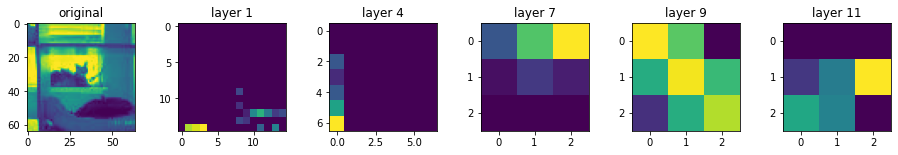

Epoch [1/50] | Test loss : 0.023026588892936708 | Test Accuracy : 10.0 %
Epoch [2/50] | Step [20/40] | Train Loss: 2.3026
Epoch [2/50] | Step [40/40] | Train Loss: 2.3011


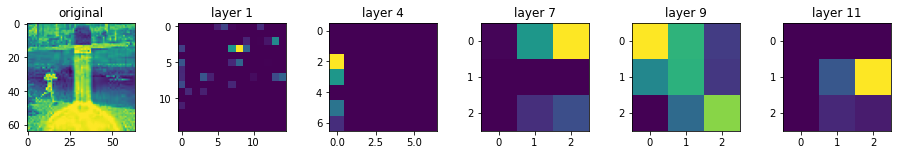

Epoch [2/50] | Test loss : 0.023026569175720213 | Test Accuracy : 10.0 %
Epoch [3/50] | Step [20/40] | Train Loss: 2.3020
Epoch [3/50] | Step [40/40] | Train Loss: 2.3024


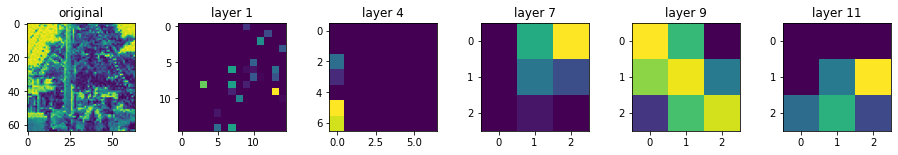

Epoch [3/50] | Test loss : 0.02302654945850372 | Test Accuracy : 10.0 %
Epoch [4/50] | Step [20/40] | Train Loss: 2.3023
Epoch [4/50] | Step [40/40] | Train Loss: 2.3043


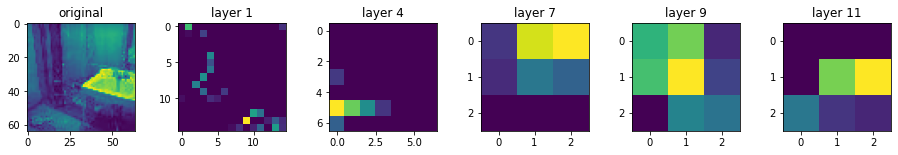

Epoch [4/50] | Test loss : 0.023026529908180236 | Test Accuracy : 10.0 %
Epoch [5/50] | Step [20/40] | Train Loss: 2.3036
Epoch [5/50] | Step [40/40] | Train Loss: 2.3023


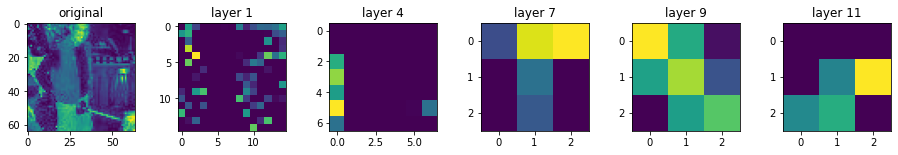

Epoch [5/50] | Test loss : 0.02302651047706604 | Test Accuracy : 10.0 %
Epoch [6/50] | Step [20/40] | Train Loss: 2.3032
Epoch [6/50] | Step [40/40] | Train Loss: 2.3035


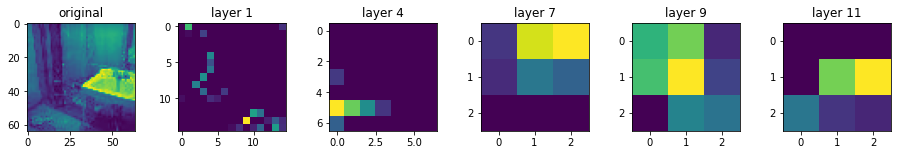

Epoch [6/50] | Test loss : 0.023026490998268128 | Test Accuracy : 10.0 %
Epoch [7/50] | Step [20/40] | Train Loss: 2.3013
Epoch [7/50] | Step [40/40] | Train Loss: 2.3032


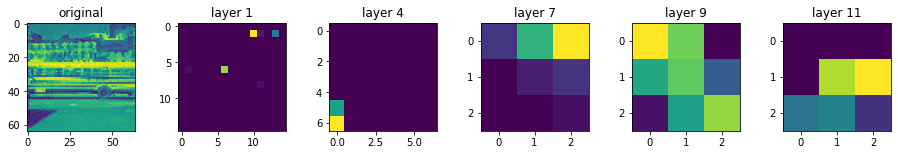

Epoch [7/50] | Test loss : 0.023026472330093382 | Test Accuracy : 10.0 %
Epoch [8/50] | Step [20/40] | Train Loss: 2.3032
Epoch [8/50] | Step [40/40] | Train Loss: 2.3012


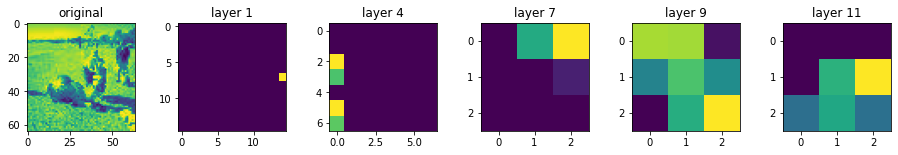

Epoch [8/50] | Test loss : 0.02302645373344421 | Test Accuracy : 10.0 %
Epoch [9/50] | Step [20/40] | Train Loss: 2.3031
Epoch [9/50] | Step [40/40] | Train Loss: 2.3034


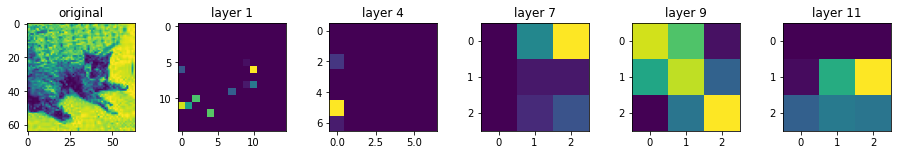

Epoch [9/50] | Test loss : 0.02302643587589264 | Test Accuracy : 10.0 %
Epoch [10/50] | Step [20/40] | Train Loss: 2.3031
Epoch [10/50] | Step [40/40] | Train Loss: 2.3020


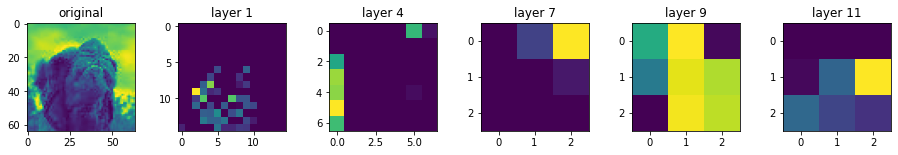

Epoch [10/50] | Test loss : 0.02302641808986664 | Test Accuracy : 10.0 %
Epoch [11/50] | Step [20/40] | Train Loss: 2.3043
Epoch [11/50] | Step [40/40] | Train Loss: 2.3017


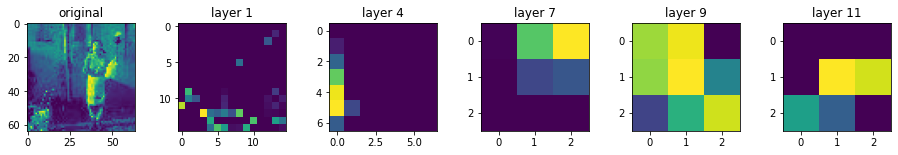

Epoch [11/50] | Test loss : 0.023026400446891783 | Test Accuracy : 10.0 %
Epoch [12/50] | Step [20/40] | Train Loss: 2.3028
Epoch [12/50] | Step [40/40] | Train Loss: 2.3030


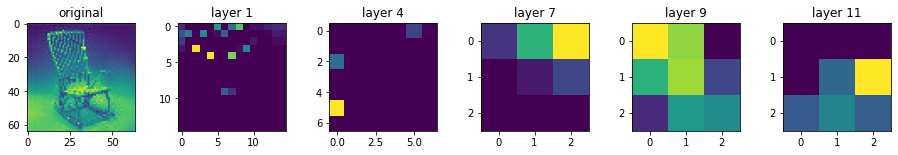

Epoch [12/50] | Test loss : 0.023026382970809934 | Test Accuracy : 10.0 %
Epoch [13/50] | Step [20/40] | Train Loss: 2.3016
Epoch [13/50] | Step [40/40] | Train Loss: 2.3004


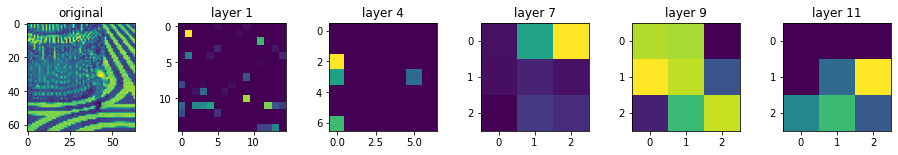

Epoch [13/50] | Test loss : 0.023026365089416502 | Test Accuracy : 10.0 %
Epoch [14/50] | Step [20/40] | Train Loss: 2.3043
Epoch [14/50] | Step [40/40] | Train Loss: 2.3031


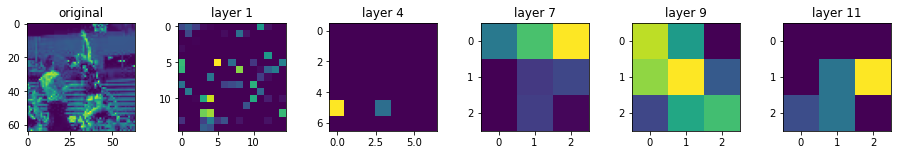

Epoch [14/50] | Test loss : 0.023026347136497496 | Test Accuracy : 10.0 %
Epoch [15/50] | Step [20/40] | Train Loss: 2.3021
Epoch [15/50] | Step [40/40] | Train Loss: 2.3029


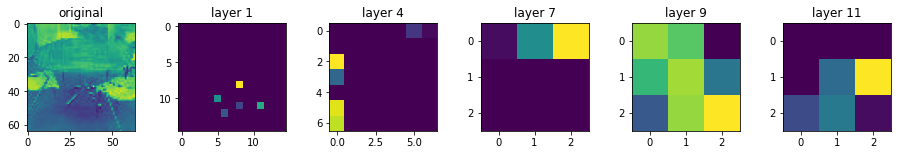

Epoch [15/50] | Test loss : 0.023026329255104065 | Test Accuracy : 10.0 %
Epoch [16/50] | Step [20/40] | Train Loss: 2.3017
Epoch [16/50] | Step [40/40] | Train Loss: 2.3022


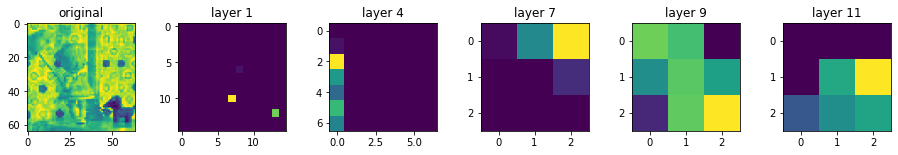

Epoch [16/50] | Test loss : 0.023026311993598936 | Test Accuracy : 10.0 %
Epoch [17/50] | Step [20/40] | Train Loss: 2.3029
Epoch [17/50] | Step [40/40] | Train Loss: 2.3016


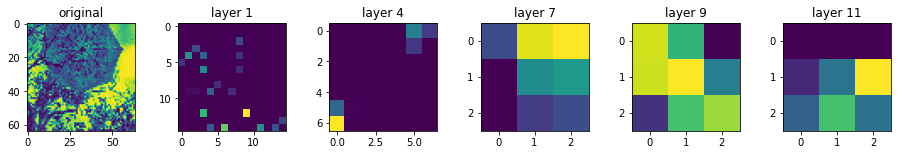

Epoch [17/50] | Test loss : 0.023026294183731078 | Test Accuracy : 10.0 %
Epoch [18/50] | Step [20/40] | Train Loss: 2.3037
Epoch [18/50] | Step [40/40] | Train Loss: 2.3040


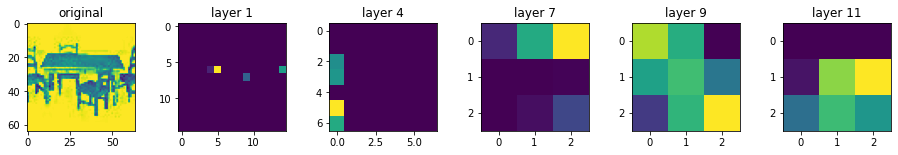

Epoch [18/50] | Test loss : 0.023026277089118957 | Test Accuracy : 10.0 %
Epoch [19/50] | Step [20/40] | Train Loss: 2.3017
Epoch [19/50] | Step [40/40] | Train Loss: 2.3028


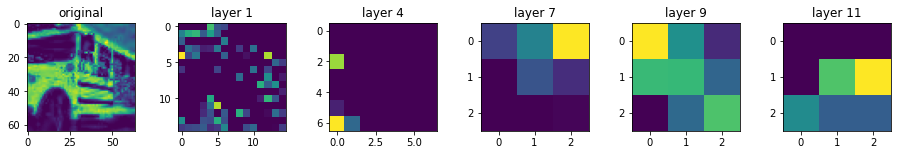

Epoch [19/50] | Test loss : 0.02302625985145569 | Test Accuracy : 10.0 %
Epoch [20/50] | Step [20/40] | Train Loss: 2.3043
Epoch [20/50] | Step [40/40] | Train Loss: 2.3013


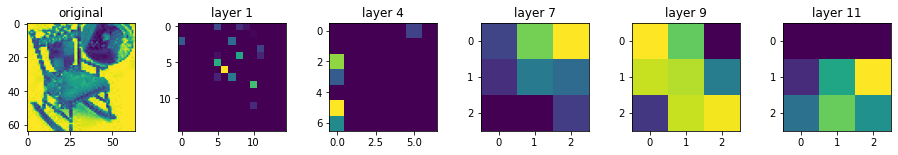

Epoch [20/50] | Test loss : 0.023026242637634278 | Test Accuracy : 10.0 %
Epoch [21/50] | Step [20/40] | Train Loss: 2.3043
Epoch [21/50] | Step [40/40] | Train Loss: 2.3035


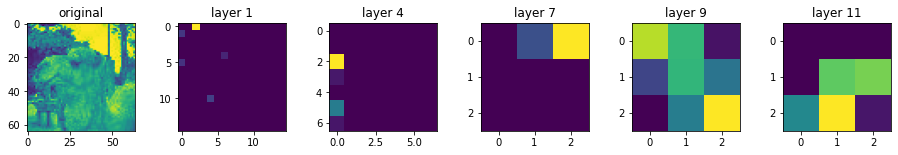

Epoch [21/50] | Test loss : 0.023026225996017457 | Test Accuracy : 10.0 %
Epoch [22/50] | Step [20/40] | Train Loss: 2.3023
Epoch [22/50] | Step [40/40] | Train Loss: 2.3029


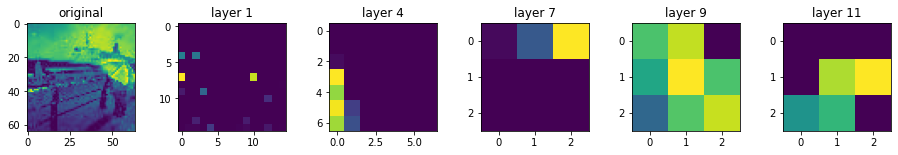

Epoch [22/50] | Test loss : 0.023026209378242495 | Test Accuracy : 10.0 %
Epoch [23/50] | Step [20/40] | Train Loss: 2.3028
Epoch [23/50] | Step [40/40] | Train Loss: 2.3050


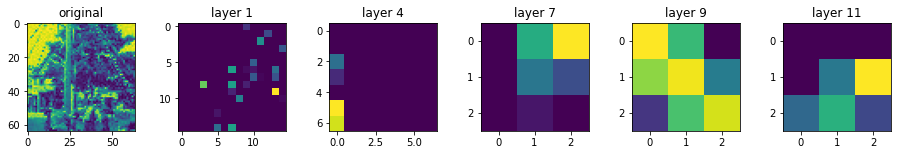

Epoch [23/50] | Test loss : 0.0230261928319931 | Test Accuracy : 10.0 %
Epoch [24/50] | Step [20/40] | Train Loss: 2.3035
Epoch [24/50] | Step [40/40] | Train Loss: 2.3021


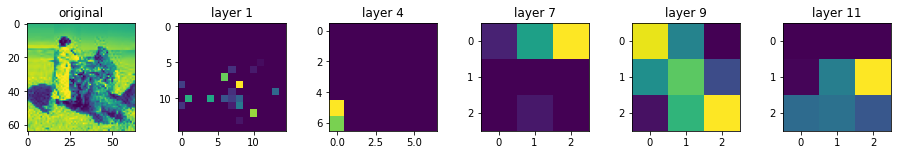

Epoch [24/50] | Test loss : 0.02302617681026459 | Test Accuracy : 10.0 %
Epoch [25/50] | Step [20/40] | Train Loss: 2.3029
Epoch [25/50] | Step [40/40] | Train Loss: 2.3037


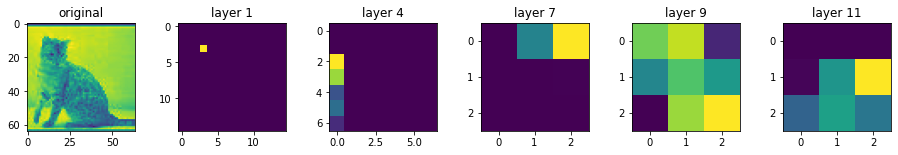

Epoch [25/50] | Test loss : 0.023026160836219788 | Test Accuracy : 10.0 %
Epoch [26/50] | Step [20/40] | Train Loss: 2.3031
Epoch [26/50] | Step [40/40] | Train Loss: 2.3021


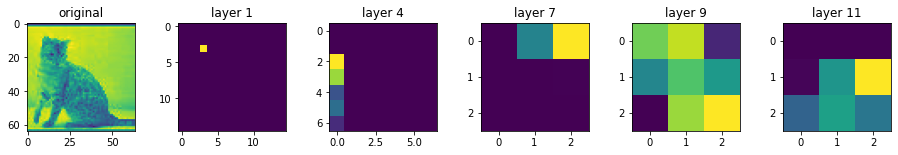

Epoch [26/50] | Test loss : 0.023026145315170287 | Test Accuracy : 10.0 %
Epoch [27/50] | Step [20/40] | Train Loss: 2.3032
Epoch [27/50] | Step [40/40] | Train Loss: 2.3028


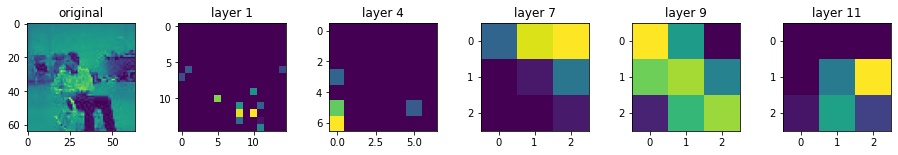

Epoch [27/50] | Test loss : 0.02302612988948822 | Test Accuracy : 10.0 %
Epoch [28/50] | Step [20/40] | Train Loss: 2.3029
Epoch [28/50] | Step [40/40] | Train Loss: 2.3031


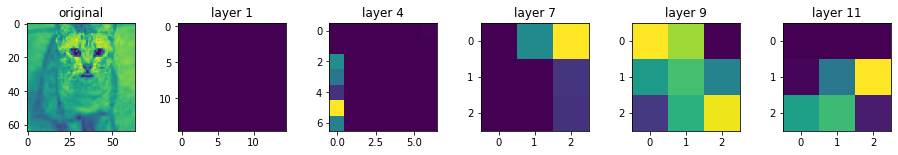

Epoch [28/50] | Test loss : 0.02302611463069916 | Test Accuracy : 10.0 %
Epoch [29/50] | Step [20/40] | Train Loss: 2.3022
Epoch [29/50] | Step [40/40] | Train Loss: 2.3029


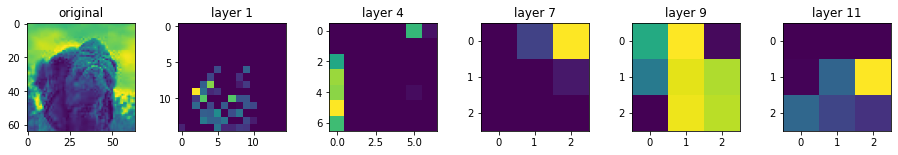

Epoch [29/50] | Test loss : 0.023026099824905395 | Test Accuracy : 10.0 %
Epoch [30/50] | Step [20/40] | Train Loss: 2.3028
Epoch [30/50] | Step [40/40] | Train Loss: 2.3044


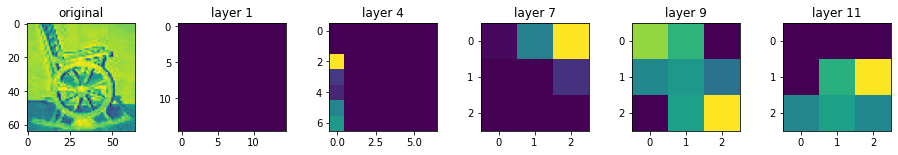

Epoch [30/50] | Test loss : 0.02302608559131622 | Test Accuracy : 10.0 %
Epoch [31/50] | Step [20/40] | Train Loss: 2.3025
Epoch [31/50] | Step [40/40] | Train Loss: 2.3031


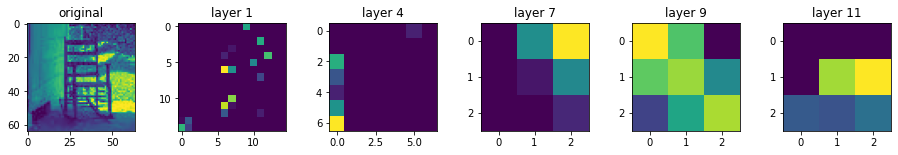

Epoch [31/50] | Test loss : 0.023026071643829346 | Test Accuracy : 10.0 %
Epoch [32/50] | Step [20/40] | Train Loss: 2.3026
Epoch [32/50] | Step [40/40] | Train Loss: 2.3014


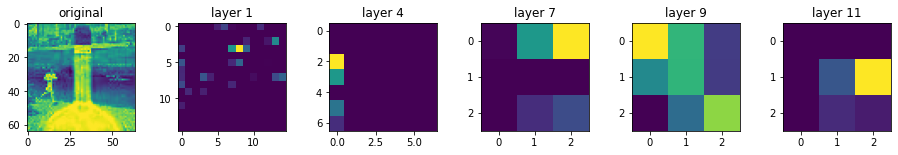

Epoch [32/50] | Test loss : 0.023026057958602904 | Test Accuracy : 10.0 %
Epoch [33/50] | Step [20/40] | Train Loss: 2.3032
Epoch [33/50] | Step [40/40] | Train Loss: 2.3019


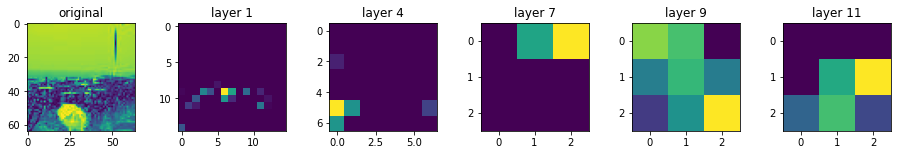

Epoch [33/50] | Test loss : 0.02302604444026947 | Test Accuracy : 10.0 %
Epoch [34/50] | Step [20/40] | Train Loss: 2.3035
Epoch [34/50] | Step [40/40] | Train Loss: 2.3030


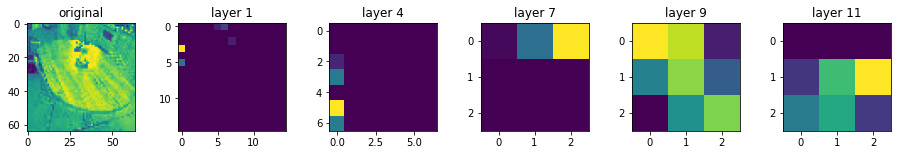

Epoch [34/50] | Test loss : 0.0230260306596756 | Test Accuracy : 10.0 %
Epoch [35/50] | Step [20/40] | Train Loss: 2.3028
Epoch [35/50] | Step [40/40] | Train Loss: 2.3016


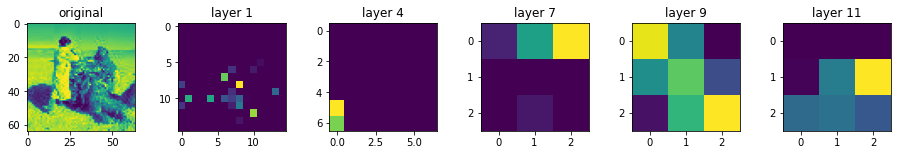

Epoch [35/50] | Test loss : 0.023026016783714295 | Test Accuracy : 10.0 %
Epoch [36/50] | Step [20/40] | Train Loss: 2.3021
Epoch [36/50] | Step [40/40] | Train Loss: 2.3033


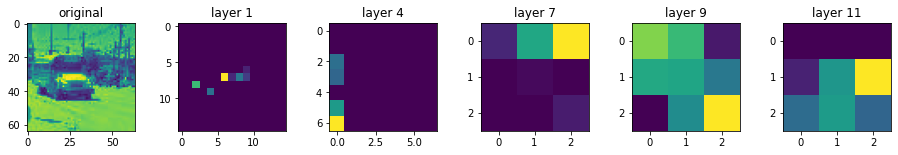

Epoch [36/50] | Test loss : 0.02302600317001343 | Test Accuracy : 10.0 %
Epoch [37/50] | Step [20/40] | Train Loss: 2.3032
Epoch [37/50] | Step [40/40] | Train Loss: 2.3034


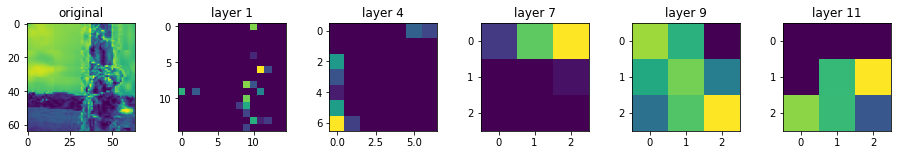

Epoch [37/50] | Test loss : 0.023025989556312562 | Test Accuracy : 10.0 %
Epoch [38/50] | Step [20/40] | Train Loss: 2.3042
Epoch [38/50] | Step [40/40] | Train Loss: 2.3031


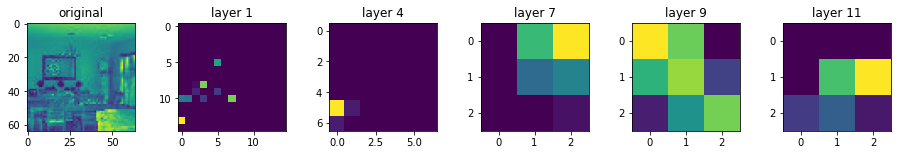

Epoch [38/50] | Test loss : 0.023025976276397703 | Test Accuracy : 10.0 %
Epoch [39/50] | Step [20/40] | Train Loss: 2.3015
Epoch [39/50] | Step [40/40] | Train Loss: 2.3037


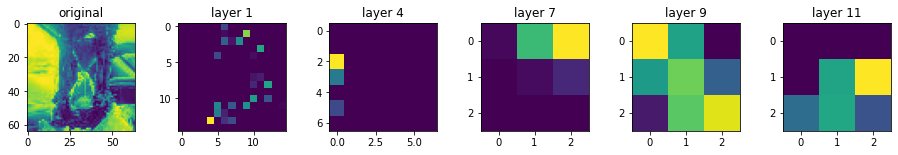

Epoch [39/50] | Test loss : 0.023025962924957274 | Test Accuracy : 10.0 %
Epoch [40/50] | Step [20/40] | Train Loss: 2.3002
Epoch [40/50] | Step [40/40] | Train Loss: 2.3024


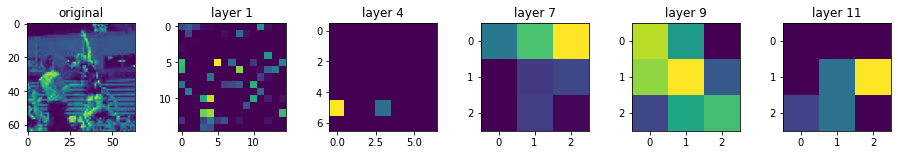

Epoch [40/50] | Test loss : 0.023025949716567996 | Test Accuracy : 10.0 %
Epoch [41/50] | Step [20/40] | Train Loss: 2.3033
Epoch [41/50] | Step [40/40] | Train Loss: 2.3017


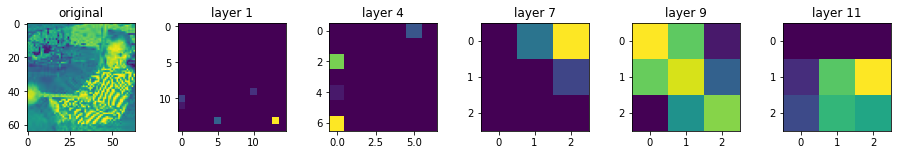

Epoch [41/50] | Test loss : 0.023025936388969423 | Test Accuracy : 10.0 %
Epoch [42/50] | Step [20/40] | Train Loss: 2.3036
Epoch [42/50] | Step [40/40] | Train Loss: 2.3022


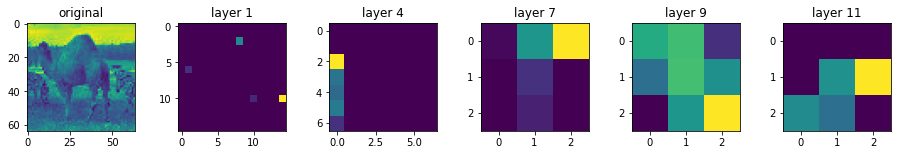

Epoch [42/50] | Test loss : 0.023025923347473144 | Test Accuracy : 10.0 %
Epoch [43/50] | Step [20/40] | Train Loss: 2.3026
Epoch [43/50] | Step [40/40] | Train Loss: 2.3028


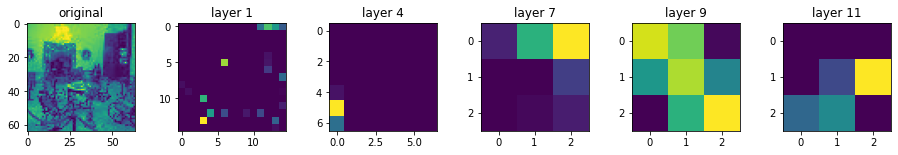

Epoch [43/50] | Test loss : 0.02302591004371643 | Test Accuracy : 10.0 %
Epoch [44/50] | Step [20/40] | Train Loss: 2.3034
Epoch [44/50] | Step [40/40] | Train Loss: 2.3009


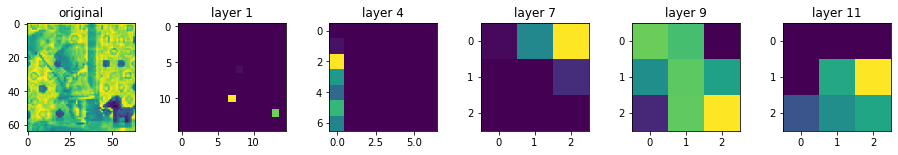

Epoch [44/50] | Test loss : 0.023025897407531738 | Test Accuracy : 10.0 %
Epoch [45/50] | Step [20/40] | Train Loss: 2.3034
Epoch [45/50] | Step [40/40] | Train Loss: 2.3028


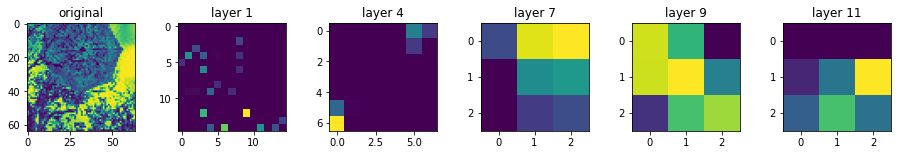

Epoch [45/50] | Test loss : 0.023025884604454042 | Test Accuracy : 10.0 %
Epoch [46/50] | Step [20/40] | Train Loss: 2.3027
Epoch [46/50] | Step [40/40] | Train Loss: 2.3014


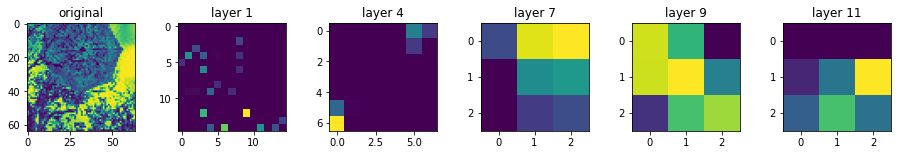

Epoch [46/50] | Test loss : 0.023025872015953065 | Test Accuracy : 10.0 %
Epoch [47/50] | Step [20/40] | Train Loss: 2.3016
Epoch [47/50] | Step [40/40] | Train Loss: 2.3039


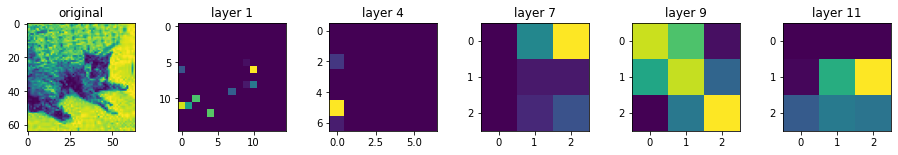

Epoch [47/50] | Test loss : 0.023025859642028808 | Test Accuracy : 10.0 %
Epoch [48/50] | Step [20/40] | Train Loss: 2.3037
Epoch [48/50] | Step [40/40] | Train Loss: 2.3024


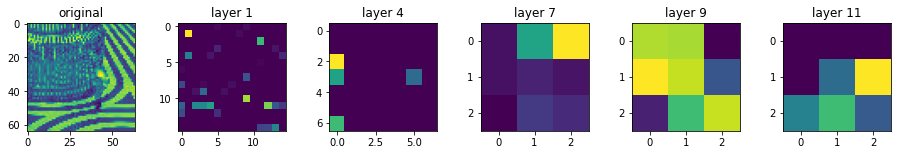

Epoch [48/50] | Test loss : 0.023025847339630125 | Test Accuracy : 10.0 %
Epoch [49/50] | Step [20/40] | Train Loss: 2.3023
Epoch [49/50] | Step [40/40] | Train Loss: 2.3020


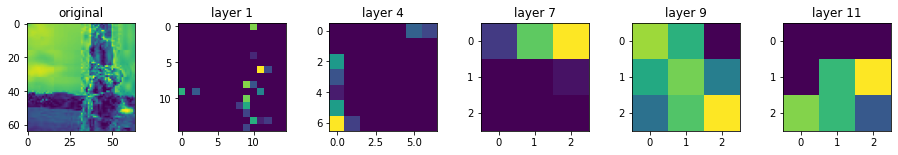

Epoch [49/50] | Test loss : 0.02302583510875702 | Test Accuracy : 10.0 %
Epoch [50/50] | Step [20/40] | Train Loss: 2.3017
Epoch [50/50] | Step [40/40] | Train Loss: 2.3010


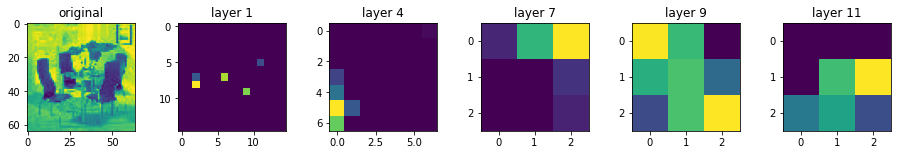

Epoch [50/50] | Test loss : 0.023025823068618775 | Test Accuracy : 10.0 %


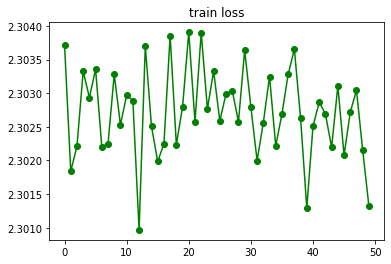

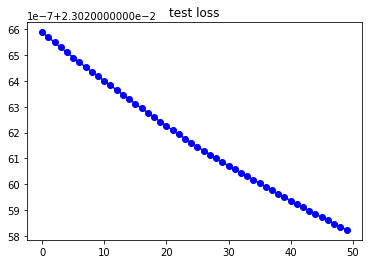

End time : 17:00:10


In [9]:
print("Start time :", datetime.now().strftime("%H:%M:%S"))
flattened_outputs_list1, original_labels_list1 = hw6q1train(loaders, alexnet_model, loss_func1, optimizer_sgd1, y_mapping, num_epochs, 'alexnet')
print("End time :", datetime.now().strftime("%H:%M:%S"))

No handles with labels found to put in legend.


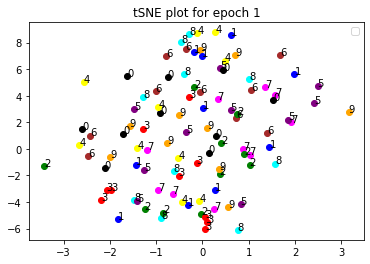

No handles with labels found to put in legend.


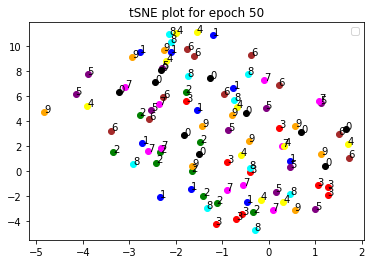

In [10]:
print(enumerate(classes))
hw6q1TSNE(flattened_outputs_list1, original_labels_list1, num_epochs)

### Resnet50

In [11]:
resnet50_model = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_resnet50', pretrained=False)
#print(resnet50_model.eval())
resnet50_model.fc = nn.Linear(2048,10)
print(resnet50_model.eval())
"""for name, module in resnet50_model.named_modules():
    print(name, type(module))
for name, module in resnet50_model.named_modules():
    if isinstance(module, tuple([torch.nn.modules.container.Sequential])) or 'Bottleneck' in str(type(module)):
        print(name, True)
    else:
        print(name, False)
"""
loss_func2 = nn.CrossEntropyLoss()
optimizer_sgd2 = optim.SGD(resnet50_model.parameters(), lr = learning_rate, momentum = 0.0)
num_epochs = 50

Using cache found in C:\Users\sanyo/.cache\torch\hub\NVIDIA_DeepLearningExamples_torchhub


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layers): Sequential(
    (0): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d

Start time : 17:00:13
Epoch [1/50] | Step [20/40] | Train Loss: 2.3647
Epoch [1/50] | Step [40/40] | Train Loss: 2.3293


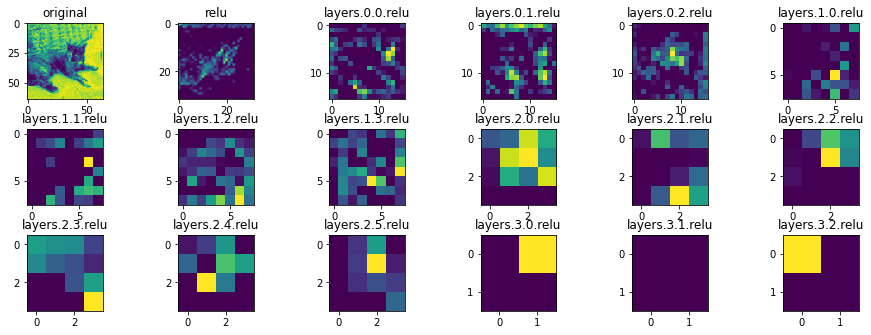

Epoch [1/50] | Test loss : 0.023449799704551695 | Test Accuracy : 17.0 %
Epoch [2/50] | Step [20/40] | Train Loss: 2.4428
Epoch [2/50] | Step [40/40] | Train Loss: 2.3485


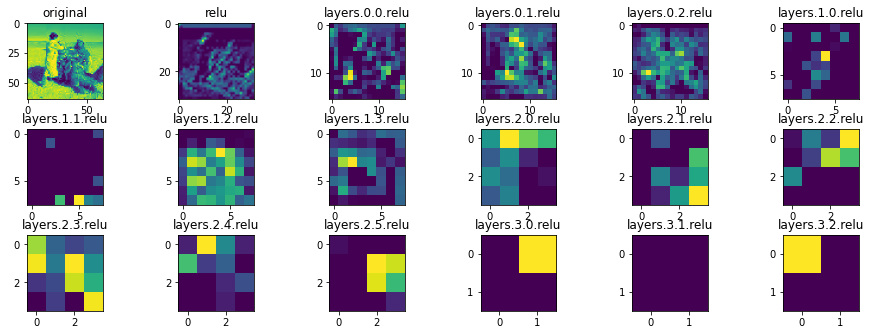

Epoch [2/50] | Test loss : 0.024816240000724795 | Test Accuracy : 10.0 %
Epoch [3/50] | Step [20/40] | Train Loss: 2.2679
Epoch [3/50] | Step [40/40] | Train Loss: 2.4959


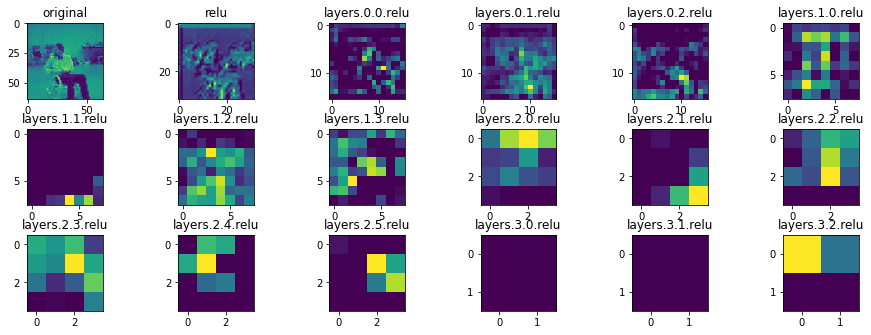

Epoch [3/50] | Test loss : 0.023590452551841733 | Test Accuracy : 17.0 %
Epoch [4/50] | Step [20/40] | Train Loss: 2.2736
Epoch [4/50] | Step [40/40] | Train Loss: 2.3148


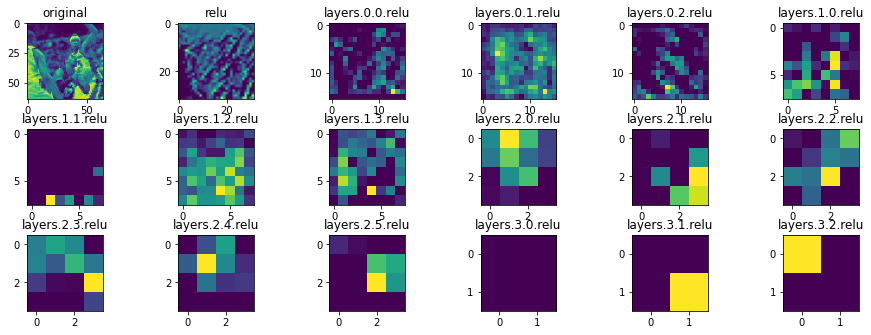

Epoch [4/50] | Test loss : 0.023325591707229615 | Test Accuracy : 9.0 %
Epoch [5/50] | Step [20/40] | Train Loss: 2.3674
Epoch [5/50] | Step [40/40] | Train Loss: 2.3482


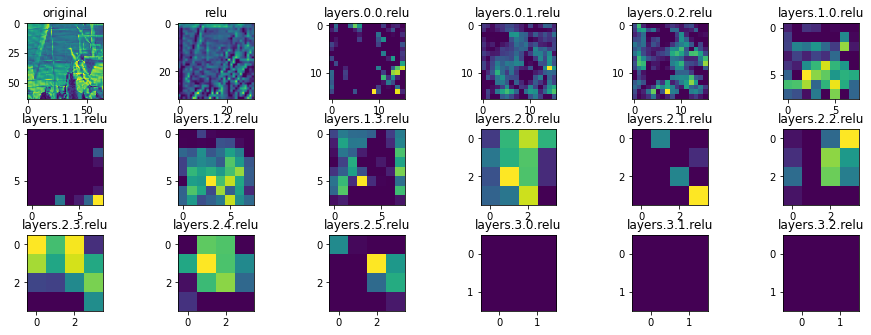

Epoch [5/50] | Test loss : 0.023655217719078064 | Test Accuracy : 8.0 %
Epoch [6/50] | Step [20/40] | Train Loss: 2.3300
Epoch [6/50] | Step [40/40] | Train Loss: 2.3355


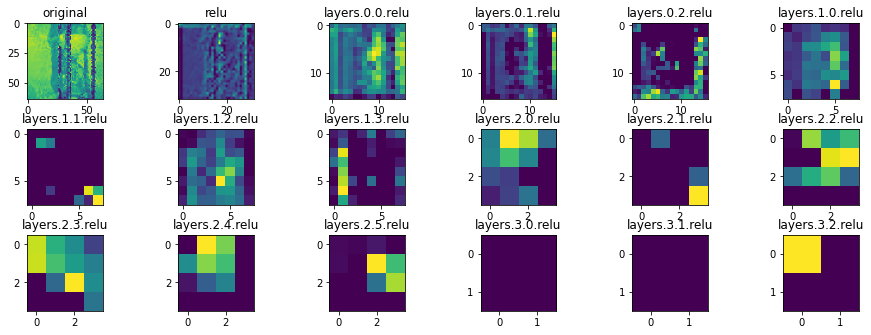

Epoch [6/50] | Test loss : 0.023102459228038788 | Test Accuracy : 14.000000000000002 %
Epoch [7/50] | Step [20/40] | Train Loss: 2.2714
Epoch [7/50] | Step [40/40] | Train Loss: 2.2936


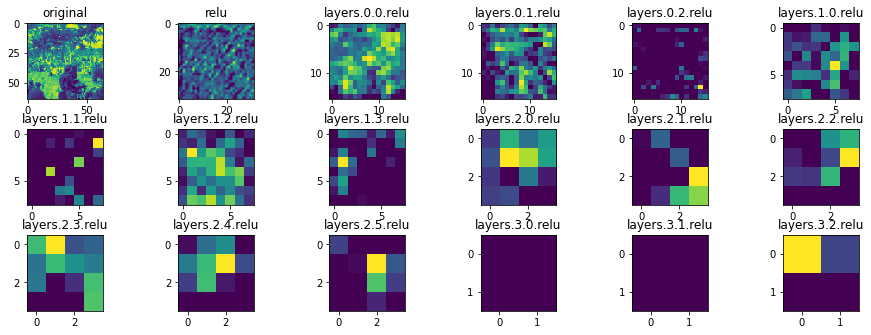

Epoch [7/50] | Test loss : 0.02346726219058037 | Test Accuracy : 10.0 %
Epoch [8/50] | Step [20/40] | Train Loss: 2.3486
Epoch [8/50] | Step [40/40] | Train Loss: 2.3466


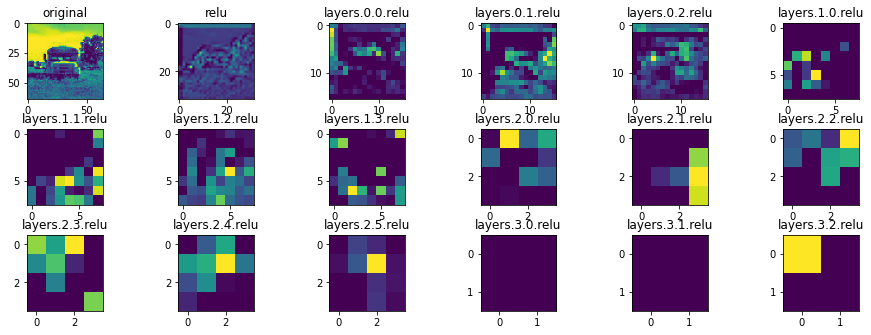

Epoch [8/50] | Test loss : 0.023597848737239836 | Test Accuracy : 11.0 %
Epoch [9/50] | Step [20/40] | Train Loss: 2.3385
Epoch [9/50] | Step [40/40] | Train Loss: 2.3351


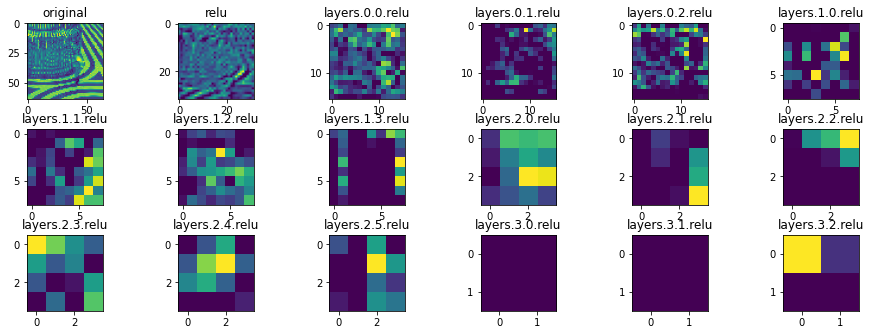

Epoch [9/50] | Test loss : 0.023090637457370757 | Test Accuracy : 11.0 %
Epoch [10/50] | Step [20/40] | Train Loss: 2.3496
Epoch [10/50] | Step [40/40] | Train Loss: 2.2948


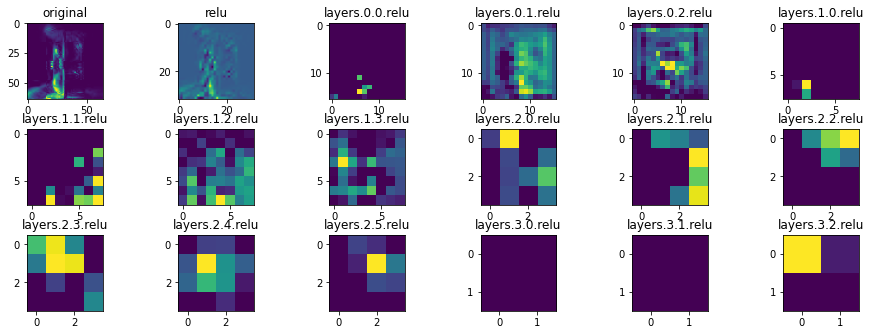

Epoch [10/50] | Test loss : 0.023090960454940794 | Test Accuracy : 10.0 %
Epoch [11/50] | Step [20/40] | Train Loss: 2.2797
Epoch [11/50] | Step [40/40] | Train Loss: 2.2890


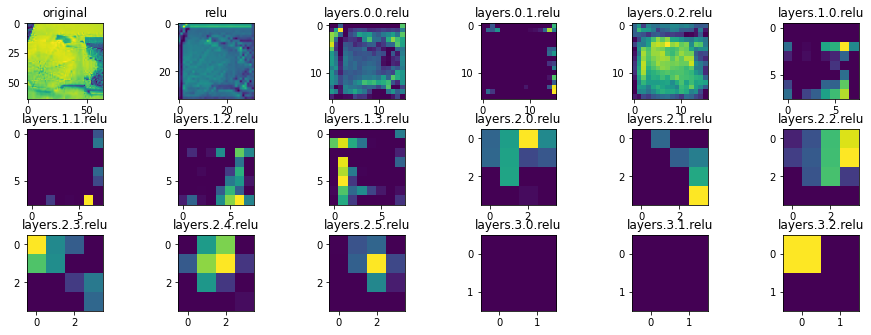

Epoch [11/50] | Test loss : 0.023312620306015015 | Test Accuracy : 13.0 %
Epoch [12/50] | Step [20/40] | Train Loss: 2.3505
Epoch [12/50] | Step [40/40] | Train Loss: 2.3336


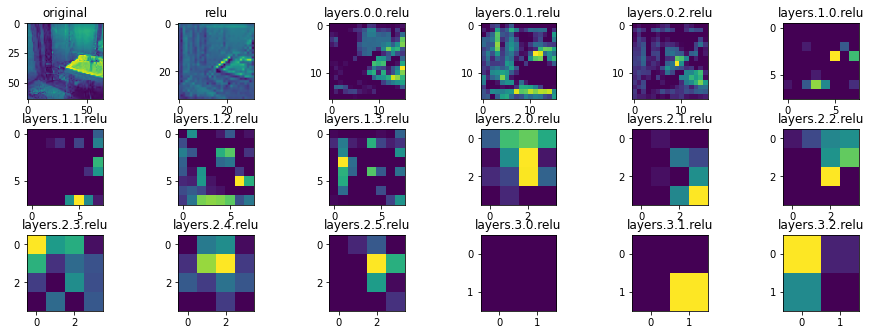

Epoch [12/50] | Test loss : 0.023139580345153808 | Test Accuracy : 16.0 %
Epoch [13/50] | Step [20/40] | Train Loss: 2.3071
Epoch [13/50] | Step [40/40] | Train Loss: 2.3859


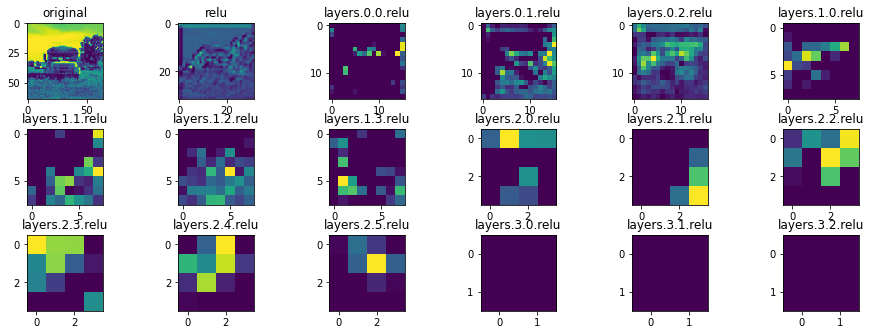

Epoch [13/50] | Test loss : 0.02307855766415596 | Test Accuracy : 14.000000000000002 %
Epoch [14/50] | Step [20/40] | Train Loss: 2.3464
Epoch [14/50] | Step [40/40] | Train Loss: 2.2258


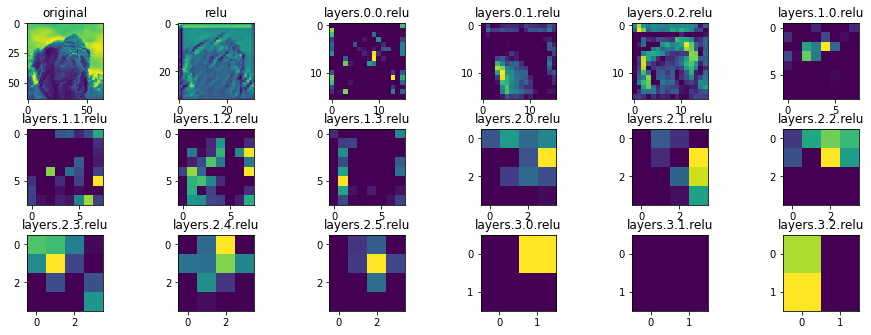

Epoch [14/50] | Test loss : 0.022947904574871062 | Test Accuracy : 13.0 %
Epoch [15/50] | Step [20/40] | Train Loss: 2.2870
Epoch [15/50] | Step [40/40] | Train Loss: 2.2465


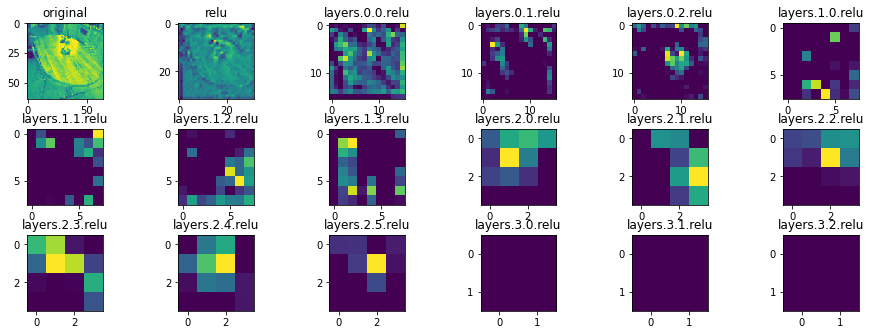

Epoch [15/50] | Test loss : 0.022851411747932433 | Test Accuracy : 12.0 %
Epoch [16/50] | Step [20/40] | Train Loss: 2.2933
Epoch [16/50] | Step [40/40] | Train Loss: 2.2138


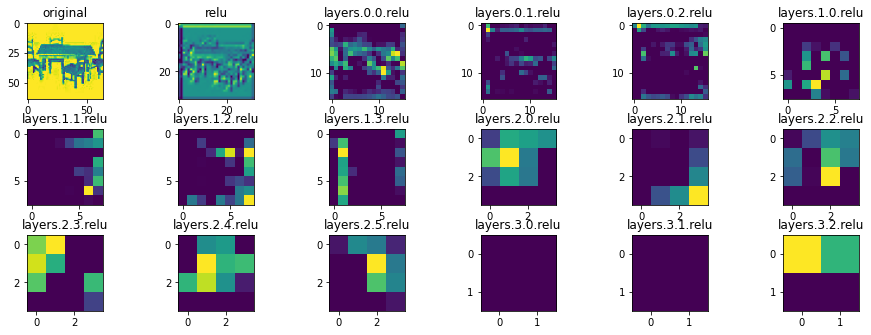

Epoch [16/50] | Test loss : 0.022471244162321092 | Test Accuracy : 15.0 %
Epoch [17/50] | Step [20/40] | Train Loss: 2.2695
Epoch [17/50] | Step [40/40] | Train Loss: 2.1707


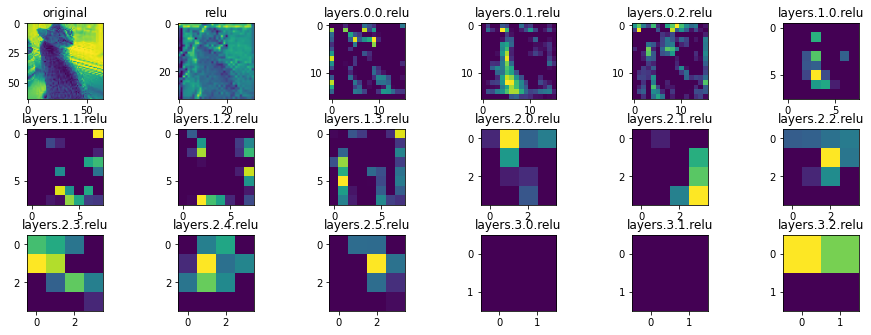

Epoch [17/50] | Test loss : 0.022147993338108064 | Test Accuracy : 15.0 %
Epoch [18/50] | Step [20/40] | Train Loss: 2.2741
Epoch [18/50] | Step [40/40] | Train Loss: 2.2799


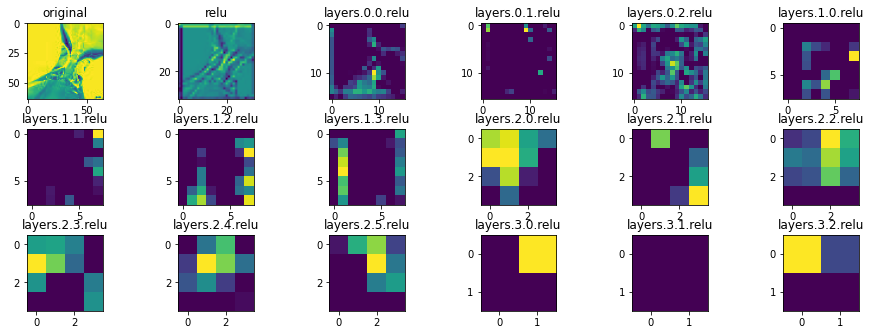

Epoch [18/50] | Test loss : 0.022098665857315063 | Test Accuracy : 11.0 %
Epoch [19/50] | Step [20/40] | Train Loss: 2.2833
Epoch [19/50] | Step [40/40] | Train Loss: 2.2635


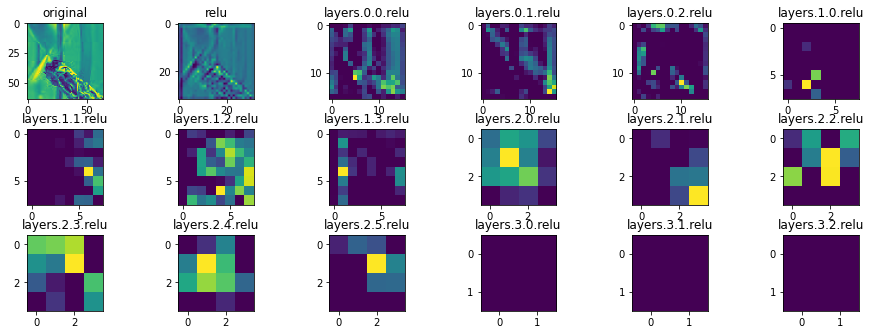

Epoch [19/50] | Test loss : 0.021777493315935134 | Test Accuracy : 18.0 %
Epoch [20/50] | Step [20/40] | Train Loss: 2.2438
Epoch [20/50] | Step [40/40] | Train Loss: 2.1506


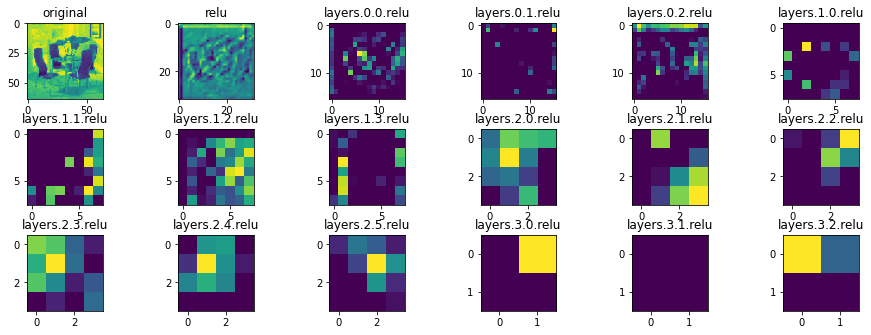

Epoch [20/50] | Test loss : 0.02189091535806656 | Test Accuracy : 24.0 %
Epoch [21/50] | Step [20/40] | Train Loss: 2.1506
Epoch [21/50] | Step [40/40] | Train Loss: 2.2005


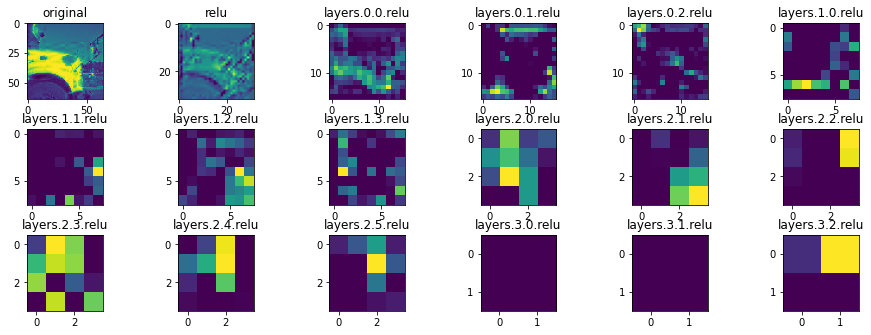

Epoch [21/50] | Test loss : 0.022004721608757973 | Test Accuracy : 17.0 %
Epoch [22/50] | Step [20/40] | Train Loss: 2.1040
Epoch [22/50] | Step [40/40] | Train Loss: 2.1871


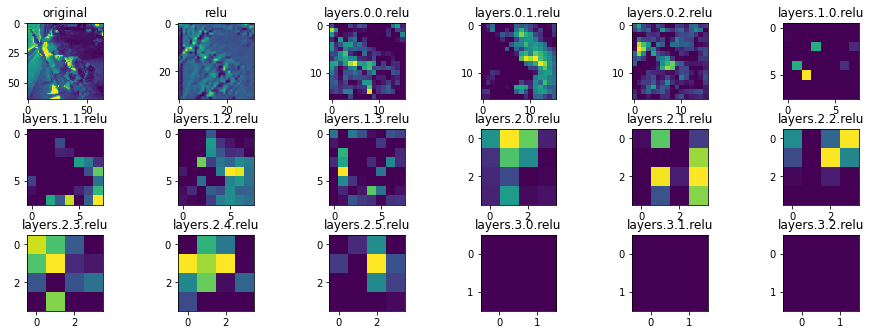

Epoch [22/50] | Test loss : 0.02188200315833092 | Test Accuracy : 21.0 %
Epoch [23/50] | Step [20/40] | Train Loss: 2.1251
Epoch [23/50] | Step [40/40] | Train Loss: 2.1455


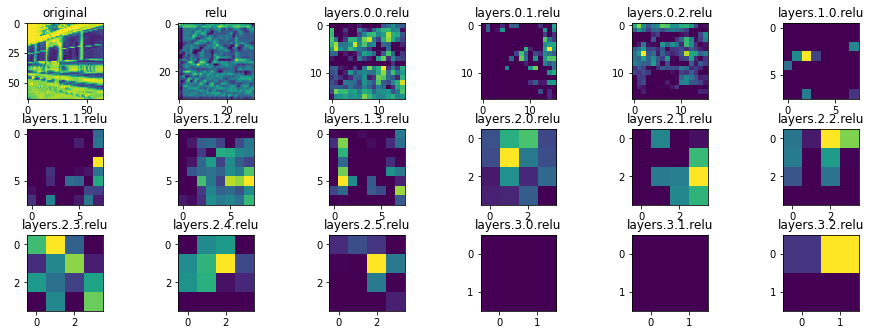

Epoch [23/50] | Test loss : 0.020538343483209612 | Test Accuracy : 25.0 %
Epoch [24/50] | Step [20/40] | Train Loss: 2.1803
Epoch [24/50] | Step [40/40] | Train Loss: 2.2183


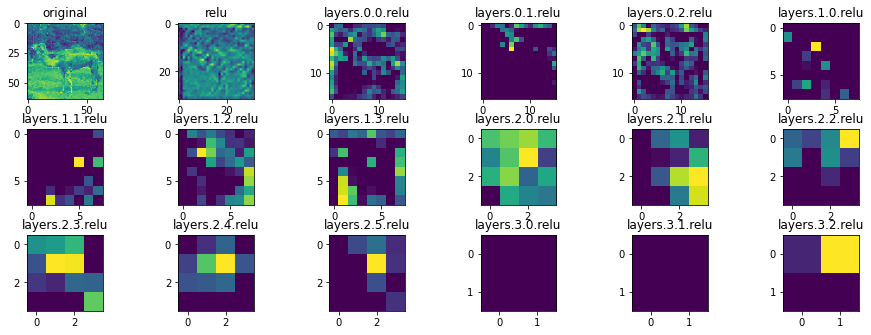

Epoch [24/50] | Test loss : 0.022222207409143446 | Test Accuracy : 18.0 %
Epoch [25/50] | Step [20/40] | Train Loss: 2.2352
Epoch [25/50] | Step [40/40] | Train Loss: 2.2097


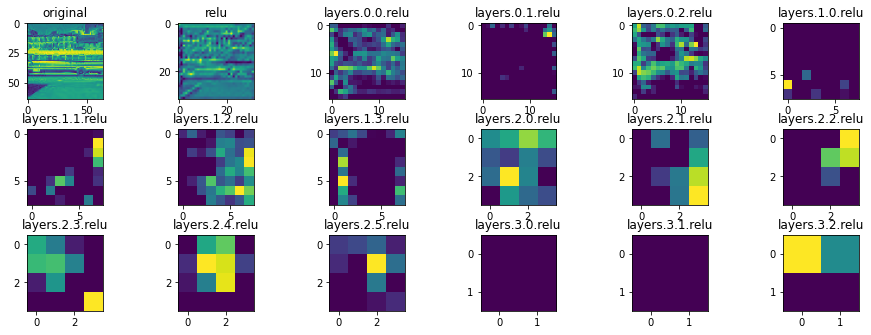

Epoch [25/50] | Test loss : 0.0212757471203804 | Test Accuracy : 17.0 %
Epoch [26/50] | Step [20/40] | Train Loss: 2.1561
Epoch [26/50] | Step [40/40] | Train Loss: 2.1328


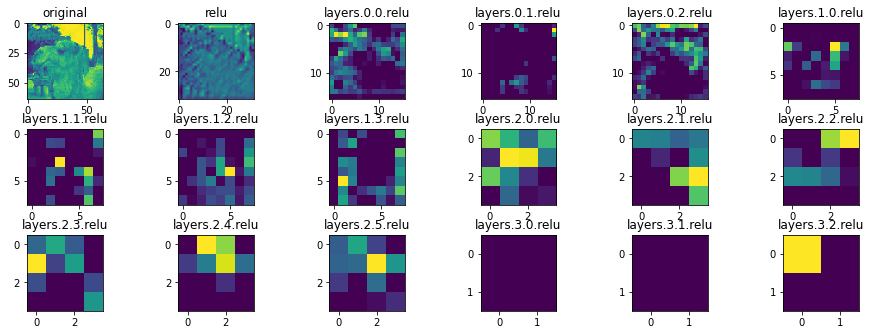

Epoch [26/50] | Test loss : 0.02096610535979271 | Test Accuracy : 23.0 %
Epoch [27/50] | Step [20/40] | Train Loss: 1.9193
Epoch [27/50] | Step [40/40] | Train Loss: 1.9870


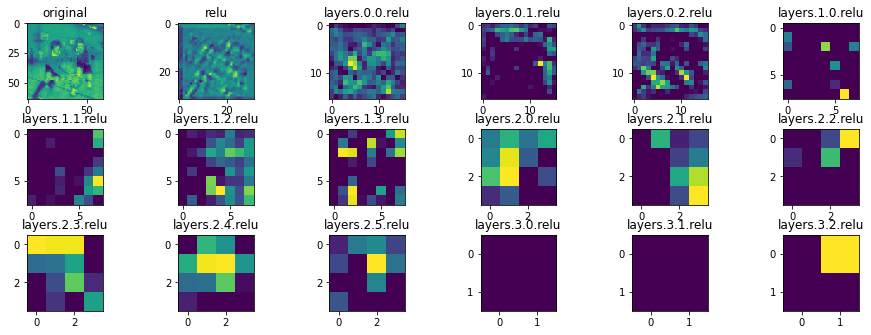

Epoch [27/50] | Test loss : 0.02010248526930809 | Test Accuracy : 22.0 %
Epoch [28/50] | Step [20/40] | Train Loss: 2.0750
Epoch [28/50] | Step [40/40] | Train Loss: 2.0249


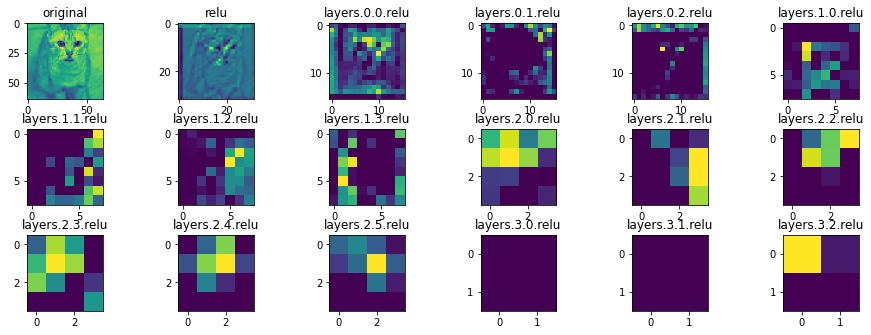

Epoch [28/50] | Test loss : 0.020852954238653184 | Test Accuracy : 21.0 %
Epoch [29/50] | Step [20/40] | Train Loss: 2.1262
Epoch [29/50] | Step [40/40] | Train Loss: 2.0975


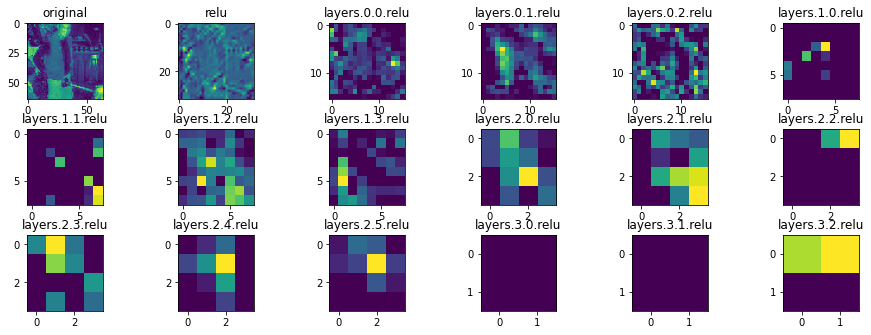

Epoch [29/50] | Test loss : 0.02075236693918705 | Test Accuracy : 21.0 %
Epoch [30/50] | Step [20/40] | Train Loss: 2.0175
Epoch [30/50] | Step [40/40] | Train Loss: 2.1091


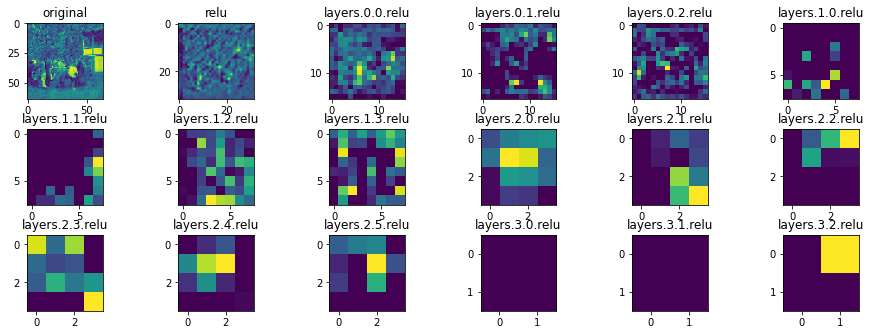

Epoch [30/50] | Test loss : 0.020580073940753937 | Test Accuracy : 26.0 %
Epoch [31/50] | Step [20/40] | Train Loss: 1.9250
Epoch [31/50] | Step [40/40] | Train Loss: 2.1215


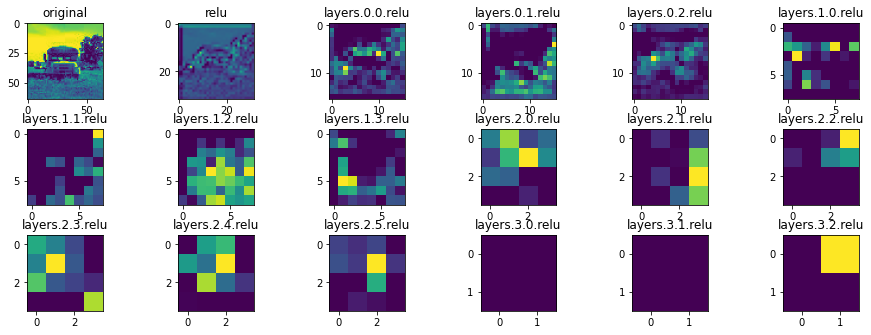

Epoch [31/50] | Test loss : 0.01986820957660675 | Test Accuracy : 28.000000000000004 %
Epoch [32/50] | Step [20/40] | Train Loss: 1.9586
Epoch [32/50] | Step [40/40] | Train Loss: 2.0054


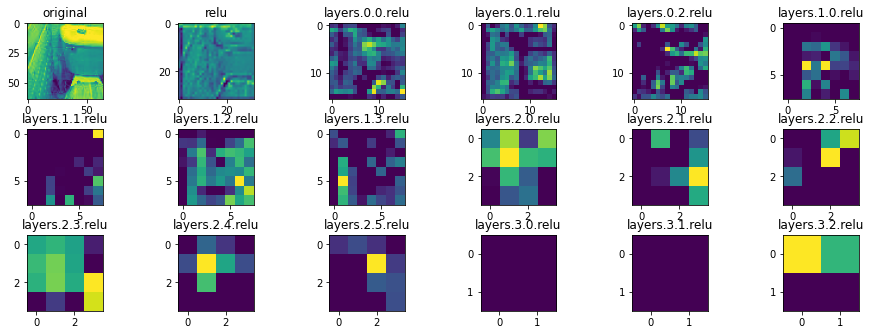

Epoch [32/50] | Test loss : 0.018662024369835856 | Test Accuracy : 36.0 %
Epoch [33/50] | Step [20/40] | Train Loss: 1.9217
Epoch [33/50] | Step [40/40] | Train Loss: 2.0241


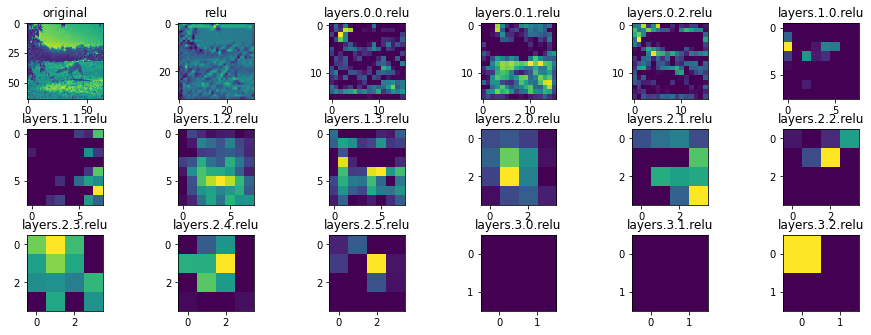

Epoch [33/50] | Test loss : 0.020180318439006806 | Test Accuracy : 28.000000000000004 %
Epoch [34/50] | Step [20/40] | Train Loss: 1.9020
Epoch [34/50] | Step [40/40] | Train Loss: 1.9345


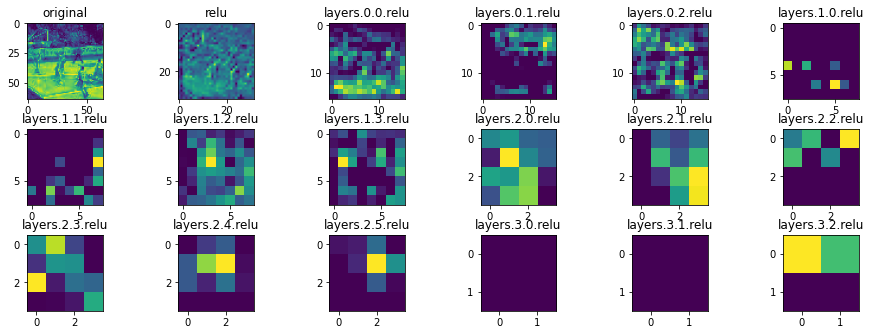

Epoch [34/50] | Test loss : 0.01990363647118211 | Test Accuracy : 28.000000000000004 %
Epoch [35/50] | Step [20/40] | Train Loss: 1.9516
Epoch [35/50] | Step [40/40] | Train Loss: 1.9526


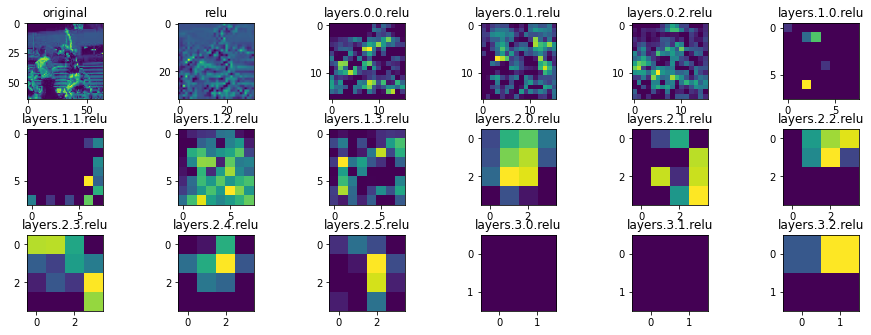

Epoch [35/50] | Test loss : 0.019754302667081357 | Test Accuracy : 32.0 %
Epoch [36/50] | Step [20/40] | Train Loss: 1.8714
Epoch [36/50] | Step [40/40] | Train Loss: 1.8939


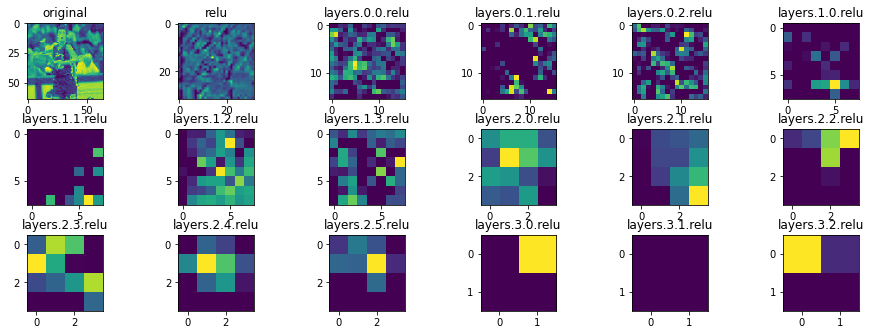

Epoch [36/50] | Test loss : 0.0183081974953413 | Test Accuracy : 36.0 %
Epoch [37/50] | Step [20/40] | Train Loss: 1.8722
Epoch [37/50] | Step [40/40] | Train Loss: 1.8559


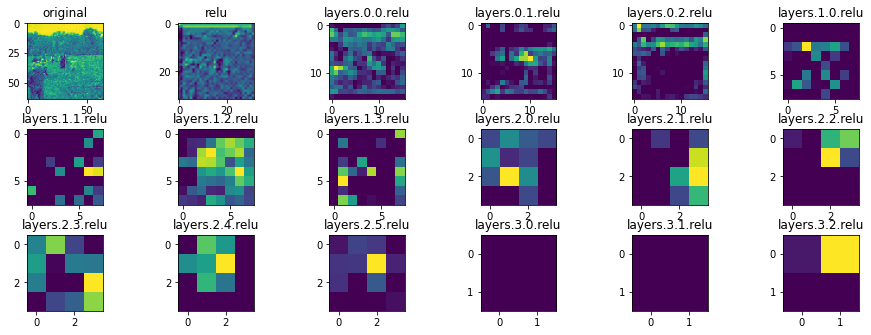

Epoch [37/50] | Test loss : 0.018236842942237853 | Test Accuracy : 30.0 %
Epoch [38/50] | Step [20/40] | Train Loss: 1.9488
Epoch [38/50] | Step [40/40] | Train Loss: 1.8559


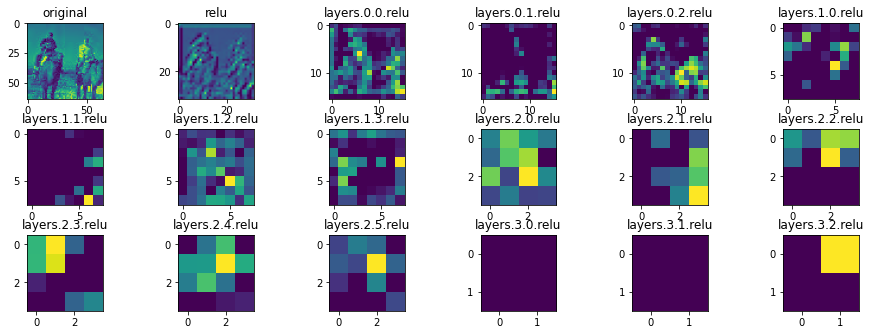

Epoch [38/50] | Test loss : 0.019104705991968514 | Test Accuracy : 32.0 %
Epoch [39/50] | Step [20/40] | Train Loss: 1.7970
Epoch [39/50] | Step [40/40] | Train Loss: 1.7504


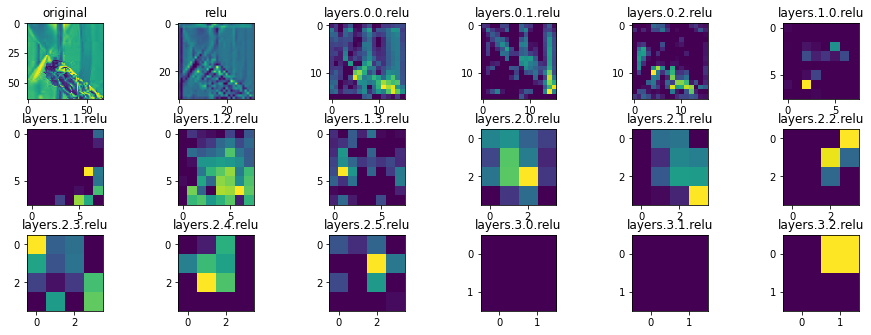

Epoch [39/50] | Test loss : 0.019447684361040593 | Test Accuracy : 32.0 %
Epoch [40/50] | Step [20/40] | Train Loss: 1.7331
Epoch [40/50] | Step [40/40] | Train Loss: 1.7671


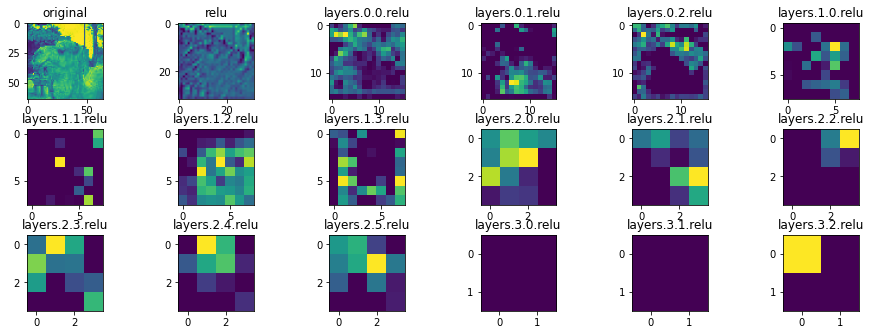

Epoch [40/50] | Test loss : 0.017896696136891842 | Test Accuracy : 28.000000000000004 %
Epoch [41/50] | Step [20/40] | Train Loss: 1.9456
Epoch [41/50] | Step [40/40] | Train Loss: 1.9733


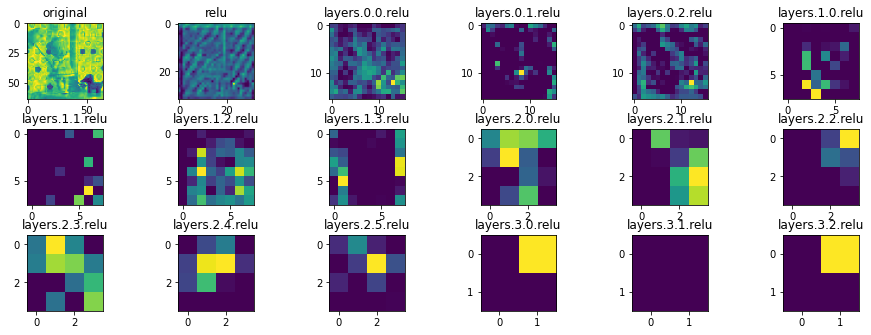

Epoch [41/50] | Test loss : 0.018835970807820557 | Test Accuracy : 33.0 %
Epoch [42/50] | Step [20/40] | Train Loss: 1.6043
Epoch [42/50] | Step [40/40] | Train Loss: 1.7398


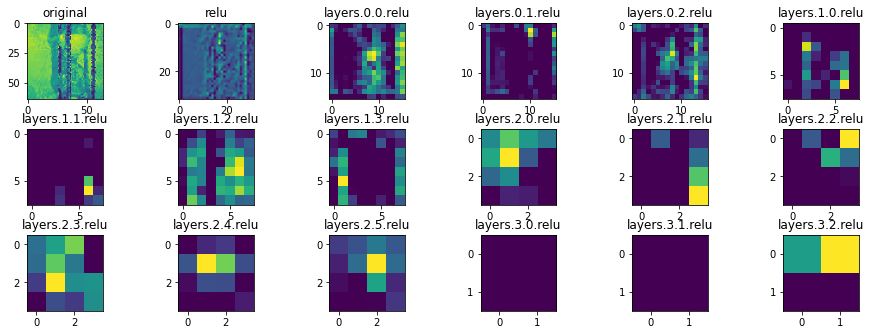

Epoch [42/50] | Test loss : 0.017778003924712536 | Test Accuracy : 38.0 %
Epoch [43/50] | Step [20/40] | Train Loss: 1.7712
Epoch [43/50] | Step [40/40] | Train Loss: 1.6820


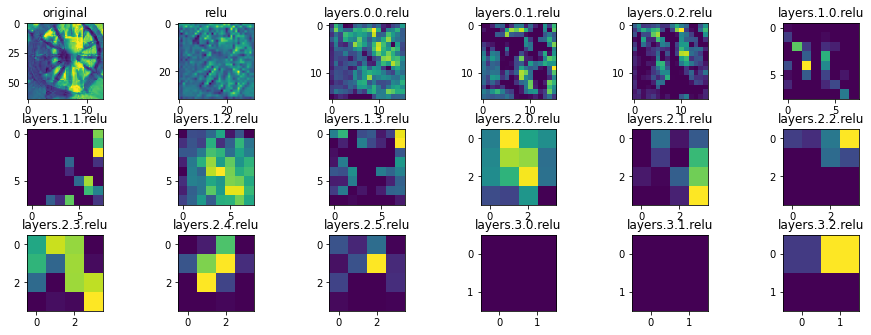

Epoch [43/50] | Test loss : 0.019128555927053096 | Test Accuracy : 38.0 %
Epoch [44/50] | Step [20/40] | Train Loss: 1.7568
Epoch [44/50] | Step [40/40] | Train Loss: 1.9377


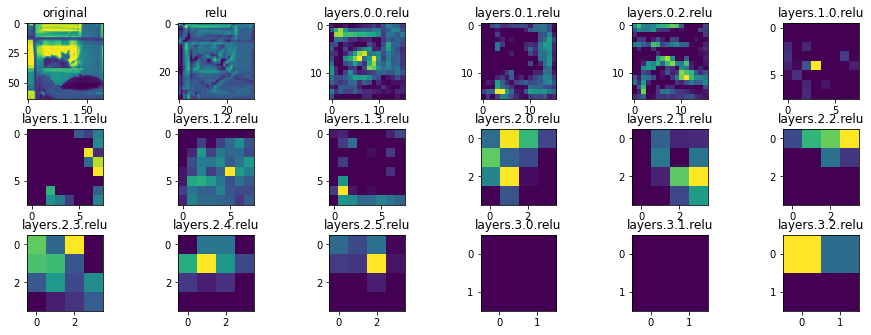

Epoch [44/50] | Test loss : 0.017873334950208663 | Test Accuracy : 37.0 %
Epoch [45/50] | Step [20/40] | Train Loss: 1.4432
Epoch [45/50] | Step [40/40] | Train Loss: 1.6085


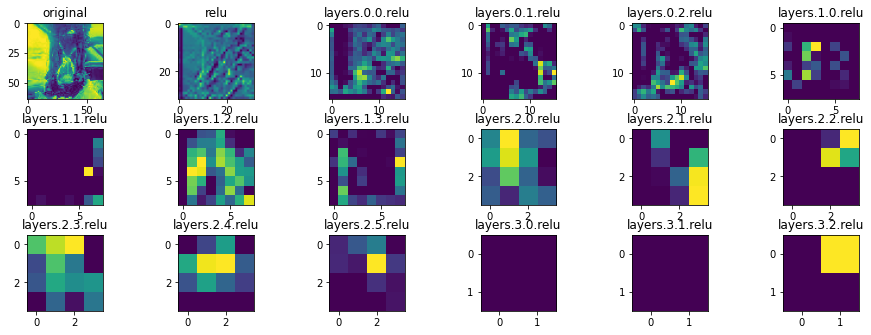

Epoch [45/50] | Test loss : 0.017558482322096825 | Test Accuracy : 37.0 %
Epoch [46/50] | Step [20/40] | Train Loss: 1.6128
Epoch [46/50] | Step [40/40] | Train Loss: 1.8159


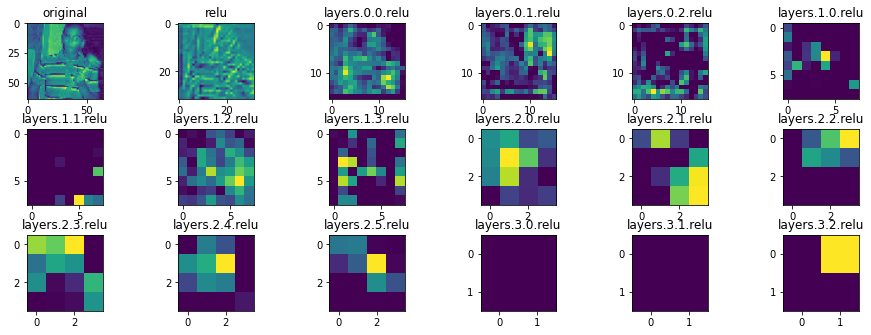

Epoch [46/50] | Test loss : 0.019088158070296048 | Test Accuracy : 33.0 %
Epoch [47/50] | Step [20/40] | Train Loss: 1.5088
Epoch [47/50] | Step [40/40] | Train Loss: 1.7368


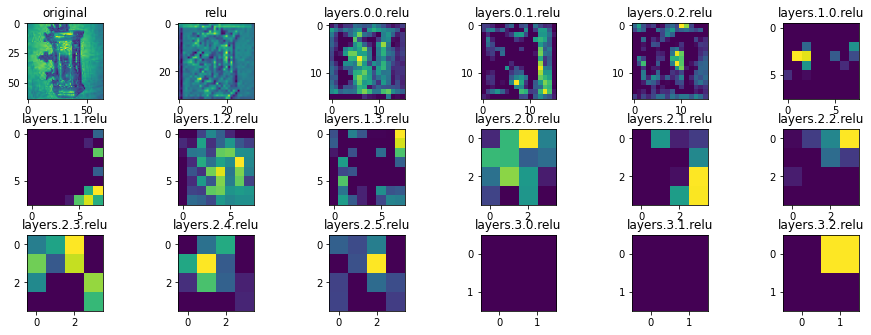

Epoch [47/50] | Test loss : 0.018048783258348702 | Test Accuracy : 39.0 %
Epoch [48/50] | Step [20/40] | Train Loss: 1.5370
Epoch [48/50] | Step [40/40] | Train Loss: 1.7551


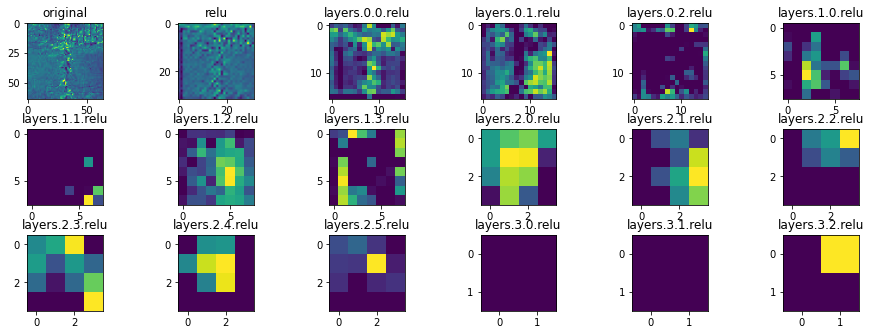

Epoch [48/50] | Test loss : 0.018934458586759864 | Test Accuracy : 32.0 %
Epoch [49/50] | Step [20/40] | Train Loss: 1.4850
Epoch [49/50] | Step [40/40] | Train Loss: 1.4202


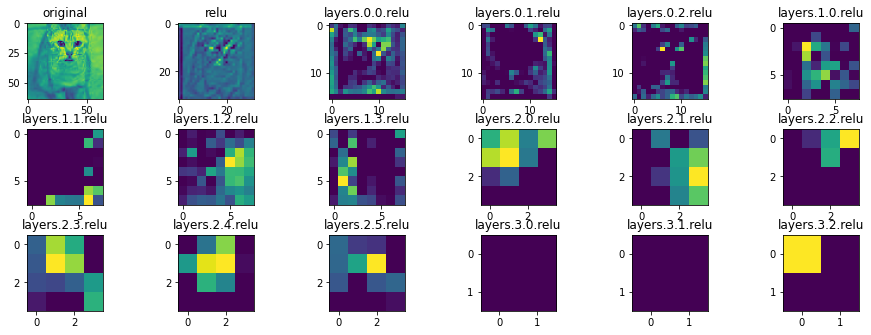

Epoch [49/50] | Test loss : 0.018300722946692258 | Test Accuracy : 35.0 %
Epoch [50/50] | Step [20/40] | Train Loss: 1.5794
Epoch [50/50] | Step [40/40] | Train Loss: 1.4738


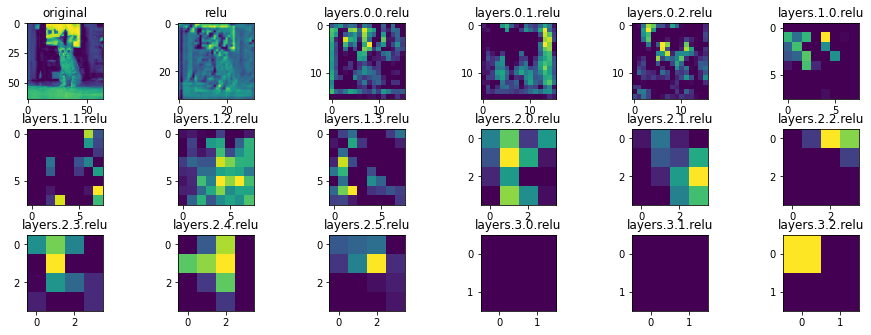

Epoch [50/50] | Test loss : 0.01789556030072272 | Test Accuracy : 36.0 %


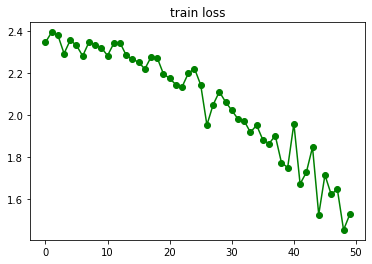

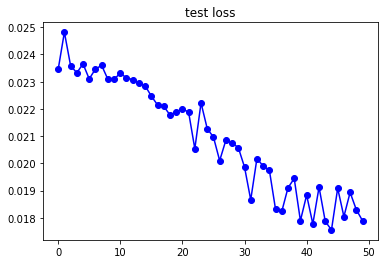

End time : 18:21:45


No handles with labels found to put in legend.


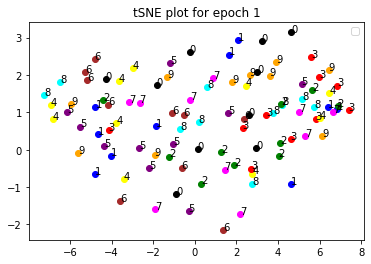

No handles with labels found to put in legend.


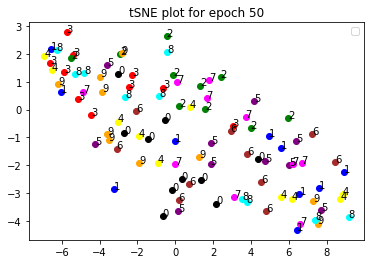

In [12]:
print("Start time :", datetime.now().strftime("%H:%M:%S"))
flattened_outputs_list2, original_labels_list2 = hw6q1train(loaders, resnet50_model, loss_func2, optimizer_sgd2, y_mapping, num_epochs, 'resnet50')
print("End time :", datetime.now().strftime("%H:%M:%S"))
print(enumerate(classes))
hw6q1TSNE(flattened_outputs_list2, original_labels_list2, num_epochs)

Alexnet model took nearly 16 minutes with final epoch test loss being 0.023025823068618775 with highest accuracy being 10 %.

Resnet50 model took nearly 81 minutes with final epoch test loss 0.01789556030072272 being with highest accuracy being 39 %.

Resnet50 model takes more time in training but obtained highest accuracy and test loss are better than Alexnet model. If time is the constraint, we can prefer using Alexnet model otherwise Resnet50 model should work find

### Q2 RNN result replication

Start time : 18:25:56
5000 5% (0m 4s) 2.8561 Chmiel / Spanish ✗ (Polish)
10000 10% (0m 9s) 1.7857 Chihachev / Russian ✓
15000 15% (0m 14s) 1.5072 Pho / Korean ✗ (Vietnamese)
20000 20% (0m 18s) 1.0403 Kong / Chinese ✓
25000 25% (0m 23s) 2.2186 Kirby / English ✓
30000 30% (0m 28s) 1.1725 Niu / Korean ✗ (Chinese)
35000 35% (0m 32s) 1.0827 Descoteaux / French ✓
40000 40% (0m 36s) 5.0079 Register / German ✗ (Irish)
45000 45% (0m 41s) 0.7440 Sun / Korean ✓
50000 50% (0m 45s) 0.6905 Mikhail / Arabic ✓
55000 55% (0m 50s) 2.2007 Mozdzierz / German ✗ (Polish)
60000 60% (0m 55s) 2.9861 Leeuwenhoeck / Vietnamese ✗ (Dutch)
65000 65% (0m 59s) 0.5852 Nguyen / Vietnamese ✓
70000 70% (1m 4s) 0.3942 Yuan / Chinese ✓
75000 75% (1m 9s) 1.4517 Bastrygin / Russian ✓
80000 80% (1m 14s) 2.0340 Maclean / Irish ✗ (Scottish)
85000 85% (1m 19s) 0.3171 Waxweiler / German ✓
90000 90% (1m 24s) 2.1699 Maria / Spanish ✗ (Portuguese)
95000 95% (1m 28s) 1.9462 Macfarland / Italian ✗ (Irish)
100000 100% (1m 33s) 1.0449 Y

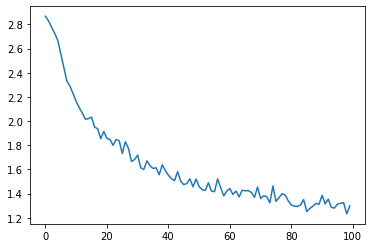

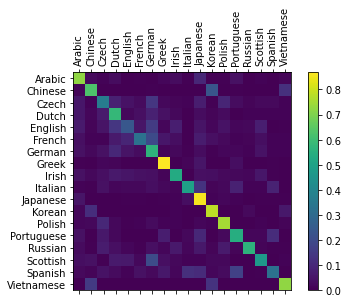


> Dovesky
(-0.50) Russian
(-1.69) Czech
(-2.43) Japanese

> Jackson
(-0.78) Scottish
(-1.22) English
(-2.47) Dutch

> Satoshi
(-0.55) Japanese
(-1.59) Arabic
(-2.20) Polish


In [18]:
#os.chdir("D:\Subjects\AI5100 - Deep Learning\Homework6")

def findFiles(path): return glob.glob(path)

#print(findFiles('data/names/*.txt'))

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

#print(categoryFromOutput(output))

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

criterion = nn.NLLLoss()

learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000

current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

print("Start time :", datetime.now().strftime("%H:%M:%S"))
for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

print("End time :", datetime.now().strftime("%H:%M:%S"))
plt.figure()
plt.plot(all_losses)
print(min(all_losses))

confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')

### GRU 

Start time : 18:28:07
5000 5% (0m 13s) 2.8078 Biganska / Spanish ✗ (Czech)
10000 10% (0m 27s) 3.0331 Sarkis / Greek ✗ (Arabic)
15000 15% (0m 40s) 3.2850 Close / Dutch ✗ (Greek)
20000 20% (0m 53s) 2.1053 Oatridge / German ✗ (English)
25000 25% (1m 5s) 2.4191 Alst / English ✗ (Dutch)
30000 30% (1m 17s) 1.8785 Mclean / Irish ✗ (Scottish)
35000 35% (1m 30s) 1.7854 Toma / Vietnamese ✗ (Arabic)
40000 40% (1m 43s) 0.4388 Masuko / Japanese ✓
45000 45% (1m 58s) 0.7046 Bradach / Irish ✓
50000 50% (2m 10s) 0.8944 Tovstyh / Russian ✓
55000 55% (2m 22s) 2.4258 Atiyeh / Irish ✗ (Arabic)
60000 60% (2m 33s) 1.9722 Saga / Vietnamese ✗ (Japanese)
65000 65% (2m 45s) 0.0684 Kunikida / Japanese ✓
70000 70% (2m 56s) 0.1409 Ferrari / Italian ✓
75000 75% (3m 8s) 0.0825 Vinci / Italian ✓
80000 80% (3m 19s) 1.4258 Heidl / Czech ✓
85000 85% (3m 31s) 1.1875 Kelly / English ✗ (Scottish)
90000 90% (3m 43s) 2.3579 Gosse / Greek ✗ (French)
95000 95% (3m 55s) 6.2294 Macdermott / French ✗ (Irish)
100000 100% (4m 7s) 0.

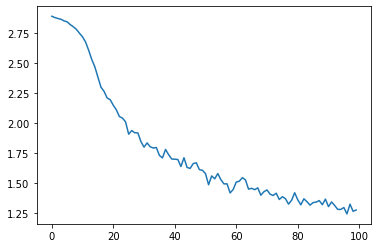

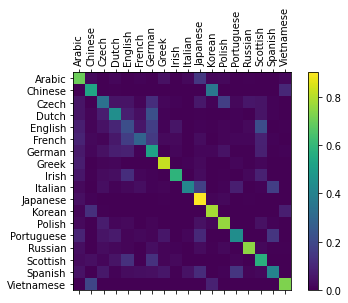


> Dovesky
(-0.48) Russian
(-1.28) Czech
(-2.92) Polish

> Jackson
(-0.23) Scottish
(-2.50) English
(-3.34) German

> Satoshi
(-0.64) Japanese
(-0.78) Arabic
(-4.75) Polish


In [19]:
class GRU1(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(GRU1, self).__init__()

        self.hidden_size = hidden_size
        self.gru = nn.GRU(input_size, hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output, hidden = self.gru(input, hidden)
        output = self.fc(output)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
gru = GRU1(n_letters, n_hidden, n_categories)

criterion1 = nn.NLLLoss()

def train1(category_tensor, line_tensor):
    hidden = gru.initHidden()

    gru.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = gru(line_tensor[i], hidden)

    loss = criterion1(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in gru.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000

current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()
print("Start time :", datetime.now().strftime("%H:%M:%S"))
for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train1(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

print("End time :", datetime.now().strftime("%H:%M:%S"))
plt.figure()
plt.plot(all_losses)
print(min(all_losses))

confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate1(line_tensor):
    hidden = gru.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = gru(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate1(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

def predict1(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate1(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict1('Dovesky')
predict1('Jackson')
predict1('Satoshi')

RNNnet model has a minimum loss of 1.2321502944072709 and it took nearly 2 minutes to train 100000 iterations.

GRUnet model has a minimum loss of 1.2458775070557604 and it took nearly 4 minutes to train 100000 iterations.

Comparing between the examples taken for prediction, lesser values are obtained for first two examples for GRUnet but not for last example.

Comparing loss, RNNnet has less loss than GRUnet.

### LSTM

Start time : 18:32:25
5000 5% (0m 13s) 2.7604 Ajibana / Dutch ✗ (Japanese)
10000 10% (0m 26s) 2.8463 Gao / Scottish ✗ (Chinese)
15000 15% (0m 39s) 2.9472 Campbell / Dutch ✗ (Scottish)
20000 20% (0m 52s) 2.7427 Chou / Korean ✓
25000 25% (1m 5s) 2.4984 Eoghan / Irish ✓
30000 30% (1m 18s) 1.5702 Batsakis / Greek ✓
35000 35% (1m 32s) 1.3768 Bui / Chinese ✗ (Vietnamese)
40000 40% (1m 47s) 1.9673 Mccallum / Scottish ✓
45000 45% (2m 3s) 1.6780 Roosevelt / Dutch ✓
50000 50% (2m 18s) 0.4724 Dasios / Greek ✓
55000 55% (2m 33s) 1.1111 Luo / Chinese ✓
60000 60% (2m 47s) 1.2094 Zha / Vietnamese ✗ (Chinese)
65000 65% (3m 1s) 0.3167 Agranov / Russian ✓
70000 70% (3m 16s) 3.1884 Langlais / Greek ✗ (French)
75000 75% (3m 30s) 2.3774 Nadvornizch / Russian ✗ (Czech)
80000 80% (3m 44s) 1.8270 Wood / Scottish ✓
85000 85% (3m 58s) 0.8168 Zavala / Spanish ✓
90000 90% (4m 12s) 0.6014 Sternberg / German ✓
95000 95% (4m 25s) 2.8053 Djigit / French ✗ (Russian)
100000 100% (4m 38s) 1.4615 Soto / Italian ✗ (Spanis

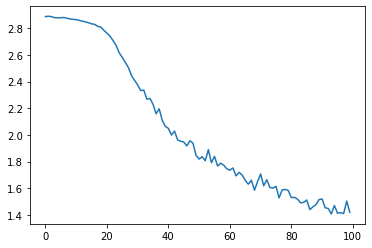

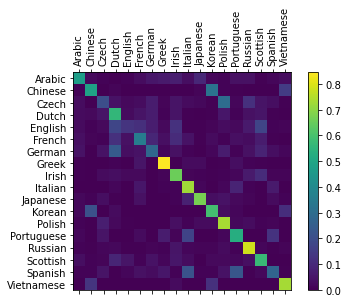


> Dovesky
(-0.40) Russian
(-1.89) Polish
(-2.59) Czech

> Jackson
(-0.49) Scottish
(-2.00) English
(-2.63) Russian

> Satoshi
(-0.61) Japanese
(-1.64) Italian
(-1.82) Polish


In [20]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTM, self).__init__()

        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output, hidden = self.lstm(input, hidden)
        output = self.fc(output)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return (torch.zeros(1, self.hidden_size), torch.zeros(1, self.hidden_size))

n_hidden = 128
lstm = LSTM(n_letters, n_hidden, n_categories)

criterion2 = nn.NLLLoss()

def train2(category_tensor, line_tensor):
    hidden = lstm.initHidden()

    lstm.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = lstm(line_tensor[i], hidden)

    loss = criterion2(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in lstm.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

n_iters = 100000
print_every = 5000
plot_every = 1000

current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

print("Start time :", datetime.now().strftime("%H:%M:%S"))
for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train2(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

print("End time :", datetime.now().strftime("%H:%M:%S"))
plt.figure()
plt.plot(all_losses)
print(min(all_losses))

confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate2(line_tensor):
    hidden = lstm.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = lstm(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate2(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

def predict2(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate2(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict2('Dovesky')
predict2('Jackson')
predict2('Satoshi')

GRUnet model has a minimum loss of 1.2458775070557604 and it took nearly 4 minutes to train 100000 iterations.

LSTMnet model has a minimum loss of 1.4085101635186001 and it took nearly 5 minutes to train 100000 iterations.

Comparing between the examples taken for prediction, lesser values are obtained for first and last examples for LSTMnet but not for second example

Comparing loss, LSTMnet has more loss than GRUnet